<a href="https://colab.research.google.com/github/Atom-101/PokeGAN/blob/master/Colab/PokeGAN_Final_30to32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleus

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

import os

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

In [0]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2

import os
from random import shuffle
import glob
import numpy as np
import h5py
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [0]:
def show_images(images):

  image = images[0]
  image += 1
  image /= 2.0
  #image = np.ceil(image)
  
  plt.axis('off')
  plt.imshow(image)

#Load

In [6]:
dat = h5py.File('drive/Pokemon/Dataset/HDF5/Pokemon_Fire_Dataset.h5', 'r')
img_array = dat['Pokemon']

print(img_array.shape)

img_array = np.asarray(img_array, dtype = np.float16)

(37962, 96, 96, 3)


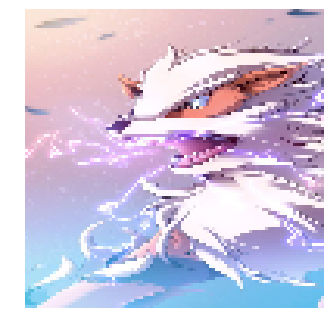

In [0]:
show_images(np.asarray(img_array[3119:3200], dtype = np.float32))
plt.show()

#Discriminator

In [0]:
def discriminator(x,isTrain,keep_prob):
  
    with tf.variable_scope("discriminator"):
        
        
        print(x.shape)
        #print([-1,tf.sqrt(tf.cast(x.shape[1],tf.float32)),tf.sqrt(tf.cast(x.shape[1],tf.float32)),1])
        #x = tf.reshape(x,[-1,(int)((int)(x.shape[1])**.5),(int)((int)(x.shape[1])**.5),1])
        
        x = tf.reshape(x,[-1,96,96,3])
        
        print(x.shape)
        
        logits = tf.layers.conv2d(x,128,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,256,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,512,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.conv2d(logits,1024,5, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        logits = tf.nn.leaky_relu(logits, alpha = 0.01)
        #logits = tf.layers.dropout(logits, rate=1-keep_prob,training=isTrain)
        #logits = tf.layers.batch_normalization(logits, training = isTrain)
        logits = tf.layers.max_pooling2d(logits,2,2)
        
        logits = tf.layers.flatten(logits)
        
        logits = tf.layers.dense(logits, 1, name = 'discriminator_out', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        
        return logits


# Generator

In [0]:
def generator(z,isTrain,keep_prob):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        
        #print(z.shape)     
        
        img = tf.layers.dense(z, 6*6*1024, activation = tf.nn.leaky_relu, kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        img = tf.layers.batch_normalization(img, training = isTrain)
        '''
        img = tf.layers.dense(img, 32*16*16, activation = tf.nn.relu, kernel_initializer=tf.random_normal_initializer(dtype=tf.float16) )
        img = tf.layers.batch_normalization(img, training = isTrain)
        '''
        img = tf.reshape(img,[-1,6,6,1024])
        
        img = tf.layers.conv2d_transpose(img, 512, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 256, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 128, 3, strides = 2, activation = tf.nn.leaky_relu, padding ='same', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        #img = tf.nn.dropout(img, keep_prob=keep_prob)
        img = tf.layers.batch_normalization(img, training = isTrain)
        
        img = tf.layers.conv2d_transpose(img, 3, 3, strides = 2, padding ='same', name = 'generator_out', kernel_initializer=tf.variance_scaling_initializer(dtype = tf.float32))
        img = tf.nn.tanh(img)
        
        print(img.shape)
        
        #img  = tf.layers.flatten(img)
        
        pass
        return img

In [0]:
def get_solvers(learning_rate=1e-4, beta1=0, beta2=0.9):

    D_solver = None
    G_solver = None
    
    D_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2=beta2, name = 'D_solver_adam')
    G_solver = tf.train.AdamOptimizer(learning_rate = learning_rate, beta1 = beta1, beta2=beta2, name = 'G_solver_adam')
    
    pass
    return D_solver, G_solver

In [0]:
def wgan_loss(logits_real, logits_fake, real_data, fake_data,keep_prob,isTrain, batch_size = 32):

  lambd = 10
  G_loss = -tf.reduce_mean(logits_fake)
  D_loss = tf.reduce_mean(logits_fake) - tf.reduce_mean(logits_real) 
  
  #Implement gradient penalty
  epsilon = tf.random_uniform([batch_size,1,1,1], minval = 0, maxval = 1)
  #interpolates = tf.multiply((1-epsilon),real_data)+tf.multiply(epsilon,fake_data) #introduce randomness using epsilon
  interpolates = (1-epsilon)*real_data + epsilon* fake_data
  with tf.variable_scope('', reuse =True):
      grads = tf.gradients(discriminator(interpolates,isTrain,keep_prob), [interpolates])[0] #why is this zero used?
  
  slopes = tf.sqrt(tf.reduce_sum(tf.square(grads))) #L2-norm
  grad_penalty = tf.reduce_mean((slopes-1.)**2)#penalty is a scalar
  
  D_loss += lambd*grad_penalty
    
  pass
  return D_loss, G_loss

In [11]:
tf.reset_default_graph()

batch_size = 32
# our noise dimension
noise_dim = 100

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 96, 96, 3])
isTrain = tf.placeholder(tf.bool, shape=(), name = 'isTrain')
keep_prob = tf.placeholder_with_default(1.0, shape=())

z = tf.random_uniform([batch_size,noise_dim],minval = -1, maxval = 1)
# generated images

G_sample = generator(z,isTrain,keep_prob)

#Variable to store D_loss of each epoch
d_losses = []

#Run when D_loss and G_loss are called
with tf.variable_scope("") as scope:
    logits_real = discriminator(x,isTrain,keep_prob)
    fake_data = G_sample
    scope.reuse_variables()
    logits_fake = discriminator(fake_data,isTrain,keep_prob)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 


D_solver,G_solver = get_solvers()
D_loss, G_loss = wgan_loss(logits_real, logits_fake, x, fake_data,keep_prob,isTrain, batch_size = batch_size)




#Update extra variables like batch_norm gamma and beta
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with tf.control_dependencies(D_extra_step):
  D_train_step = D_solver.minimize(D_loss, var_list=D_vars)

with tf.control_dependencies(G_extra_step):
  G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


(32, 96, 96, 3)
(?, 96, 96, 3)
(?, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)
(32, 96, 96, 3)


In [0]:
def minibatches(inputs, batchsize):
    indices = np.arange(inputs.shape[0])
    np.random.shuffle(indices)
    x = []
    for i in range(batchsize):
        x.append(inputs[indices[i]])
    return np.asarray(x)

In [0]:
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step, saver,
                     show_every=20, print_every=1, batch_size=32, num_epoch=10):
   
   
    for epoch in range(30799,30799+num_epoch):
        prob = 1 - 0.4**epoch #ranges from 0.6 to 1
        #X = minibatches(img_array,batch_size)
        # every so often, show a sample result
        if (epoch % show_every == 0):
            samples = sess.run(G_sample, feed_dict={isTrain:False})
            fig = show_images(samples[:4])
            plt.show()
            #Save image samples generated while training
            
            print()
        
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict={isTrain:True,keep_prob:prob})
           
        #Train critic 5 times per epoch
        for _ in range(5):
          X = minibatches(img_array,batch_size)
          _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: X, isTrain:True,keep_prob:prob})
          

        #Various displays
        if (epoch % print_every == 0):
            print('Epoch: {}, D: {:.4}, G: {:.4}'.format(epoch,D_loss_curr,G_loss_curr))
        
        #Save stuff every 400 epochs
        if (epoch % 400 == 399):    
          try: 
            saver.save(sess, 'drive/Pokemon_Fire/Final_Checkpoints/Model_'+str(epoch)+'.ckpt')
            np.save('drive/Pokemon_Fire/Final_Discriminator_loss.npy', np.asarray(d_losses))
          except:
            pass
          
          
        d_losses.append(D_loss_curr)
          
        if(epoch%500 == 0):  
          try:
            if(epoch>=1000):
                 with h5py.File('drive/Pokemon_Fire/Final_gen_while_training.h5','a') as file:
                     file.create_dataset('Samples'+str(epoch),samples.shape, np.float32)
                     file['Samples'+str(epoch)][...] = np.asarray(samples, dtype = np.float32)
          except:
            pass

    
    saver.save(sess, 'drive/Pokemon_Fire/Final_Checkpoint_Complete/model.ckpt')
    
    print('Final images')
    samples = sess.run(G_sample, feed_dict={isTrain:False})
    fig = show_images(samples1[:4])
    plt.show()

drive/Pokemon_Fire/Final_Checkpoints/Model_30799.ckpt
INFO:tensorflow:Restoring parameters from drive/Pokemon_Fire/Final_Checkpoints/Model_30799.ckpt
Restored!
Epoch: 30799, D: -6.37, G: 3.107


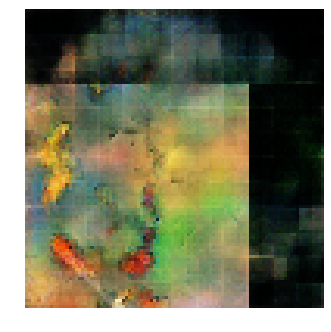


Epoch: 30800, D: -6.626, G: 5.519
Epoch: 30801, D: -5.566, G: 3.96
Epoch: 30802, D: -6.461, G: 5.037
Epoch: 30803, D: -6.334, G: 3.046
Epoch: 30804, D: -6.799, G: 4.577
Epoch: 30805, D: -7.492, G: 4.685
Epoch: 30806, D: -5.685, G: 5.079
Epoch: 30807, D: -5.751, G: 3.826
Epoch: 30808, D: -5.583, G: 3.626
Epoch: 30809, D: -6.373, G: 5.796
Epoch: 30810, D: -6.884, G: 5.634
Epoch: 30811, D: -6.936, G: 3.721
Epoch: 30812, D: -5.043, G: 5.514
Epoch: 30813, D: -6.881, G: 4.707
Epoch: 30814, D: -7.025, G: 4.263
Epoch: 30815, D: -6.723, G: 4.876
Epoch: 30816, D: -6.13, G: 4.293
Epoch: 30817, D: -5.353, G: 2.525
Epoch: 30818, D: -5.769, G: 2.355
Epoch: 30819, D: -6.328, G: 2.653


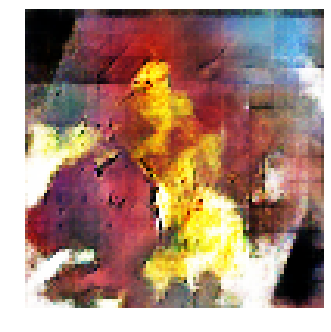


Epoch: 30820, D: -6.894, G: 4.298
Epoch: 30821, D: -5.837, G: 2.848
Epoch: 30822, D: -5.75, G: 3.78
Epoch: 30823, D: -5.904, G: 4.682
Epoch: 30824, D: -6.026, G: 3.527
Epoch: 30825, D: -5.431, G: 3.051
Epoch: 30826, D: -7.508, G: 3.589
Epoch: 30827, D: -6.042, G: 5.219
Epoch: 30828, D: -6.265, G: 3.301
Epoch: 30829, D: -6.951, G: 5.514
Epoch: 30830, D: -5.256, G: 4.222
Epoch: 30831, D: -6.141, G: 4.395
Epoch: 30832, D: -6.217, G: 5.134
Epoch: 30833, D: -5.511, G: 4.609
Epoch: 30834, D: -5.333, G: 3.932
Epoch: 30835, D: -6.599, G: 4.193
Epoch: 30836, D: -4.435, G: 3.227
Epoch: 30837, D: -6.859, G: 4.316
Epoch: 30838, D: -7.597, G: 3.087
Epoch: 30839, D: -6.736, G: 3.01


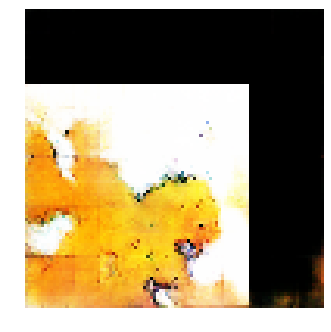


Epoch: 30840, D: -4.814, G: 4.028
Epoch: 30841, D: -6.11, G: 3.847
Epoch: 30842, D: -4.946, G: 2.232
Epoch: 30843, D: -6.147, G: 4.38
Epoch: 30844, D: -5.582, G: 4.781
Epoch: 30845, D: -5.688, G: 6.211
Epoch: 30846, D: -6.068, G: 4.194
Epoch: 30847, D: -6.962, G: 2.778
Epoch: 30848, D: -6.728, G: 4.225
Epoch: 30849, D: -6.609, G: 3.774
Epoch: 30850, D: -6.891, G: 3.499
Epoch: 30851, D: -5.857, G: 4.985
Epoch: 30852, D: -5.015, G: 4.839
Epoch: 30853, D: -6.273, G: 1.755
Epoch: 30854, D: -6.699, G: 2.802
Epoch: 30855, D: -5.76, G: 4.019
Epoch: 30856, D: -8.167, G: 2.462
Epoch: 30857, D: -7.067, G: 2.718
Epoch: 30858, D: -5.939, G: 3.866
Epoch: 30859, D: -5.909, G: 4.502


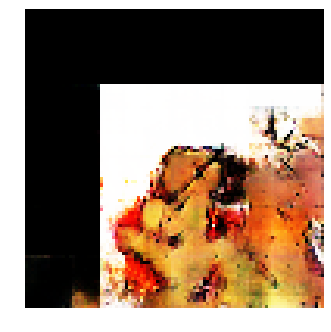


Epoch: 30860, D: -5.48, G: 3.313
Epoch: 30861, D: -6.686, G: 3.931
Epoch: 30862, D: -6.201, G: 4.378
Epoch: 30863, D: -6.548, G: 4.515
Epoch: 30864, D: -6.215, G: 2.928
Epoch: 30865, D: -6.143, G: 4.814
Epoch: 30866, D: -5.766, G: 4.847
Epoch: 30867, D: -5.654, G: 3.342
Epoch: 30868, D: -7.514, G: 2.483
Epoch: 30869, D: -6.028, G: 4.185
Epoch: 30870, D: -6.518, G: 1.202
Epoch: 30871, D: -6.267, G: 3.205
Epoch: 30872, D: -7.251, G: 4.948
Epoch: 30873, D: -5.193, G: 2.384
Epoch: 30874, D: -5.3, G: 4.421
Epoch: 30875, D: -6.412, G: 3.567
Epoch: 30876, D: -7.18, G: 3.145
Epoch: 30877, D: -5.087, G: 2.627
Epoch: 30878, D: -5.76, G: 4.719
Epoch: 30879, D: -6.093, G: 0.6979


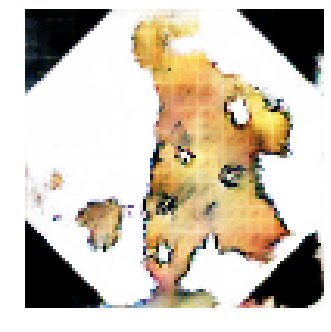


Epoch: 30880, D: -5.901, G: 3.21
Epoch: 30881, D: -5.54, G: 2.653
Epoch: 30882, D: -5.59, G: 2.116
Epoch: 30883, D: -5.675, G: 3.291
Epoch: 30884, D: -5.278, G: 1.87
Epoch: 30885, D: -5.074, G: 4.45
Epoch: 30886, D: -4.85, G: 4.28
Epoch: 30887, D: -6.348, G: 4.566
Epoch: 30888, D: -6.506, G: 5.615
Epoch: 30889, D: -6.616, G: 4.179
Epoch: 30890, D: -5.31, G: 4.417
Epoch: 30891, D: -6.316, G: 2.848
Epoch: 30892, D: -4.232, G: 4.791
Epoch: 30893, D: -6.164, G: 3.213
Epoch: 30894, D: -6.872, G: 3.888
Epoch: 30895, D: -6.946, G: 3.371
Epoch: 30896, D: -7.744, G: 4.043
Epoch: 30897, D: -4.985, G: 4.023
Epoch: 30898, D: -8.368, G: 4.509
Epoch: 30899, D: -6.062, G: 3.363


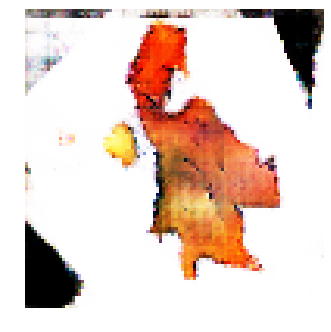


Epoch: 30900, D: -6.784, G: 2.405
Epoch: 30901, D: -6.012, G: 3.614
Epoch: 30902, D: -7.295, G: 3.156
Epoch: 30903, D: -5.367, G: 5.146
Epoch: 30904, D: -5.8, G: 4.924
Epoch: 30905, D: -5.758, G: 4.939
Epoch: 30906, D: -4.868, G: 2.925
Epoch: 30907, D: -5.482, G: 2.603
Epoch: 30908, D: -7.057, G: 4.881
Epoch: 30909, D: -5.521, G: 2.707
Epoch: 30910, D: -4.926, G: 5.148
Epoch: 30911, D: -7.657, G: 4.205
Epoch: 30912, D: -6.696, G: 5.298
Epoch: 30913, D: -4.859, G: 3.266
Epoch: 30914, D: -6.7, G: 4.867
Epoch: 30915, D: -4.586, G: 2.948
Epoch: 30916, D: -5.465, G: 2.996
Epoch: 30917, D: -6.121, G: 4.857
Epoch: 30918, D: -6.031, G: 2.456
Epoch: 30919, D: -5.193, G: 6.118


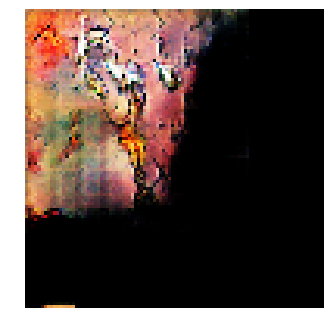


Epoch: 30920, D: -5.456, G: 4.489
Epoch: 30921, D: -6.047, G: 4.888
Epoch: 30922, D: -5.076, G: 5.514
Epoch: 30923, D: -7.275, G: 3.897
Epoch: 30924, D: -5.461, G: 3.025
Epoch: 30925, D: -6.993, G: 3.255
Epoch: 30926, D: -6.251, G: 3.891
Epoch: 30927, D: -6.685, G: 5.013
Epoch: 30928, D: -5.776, G: 3.702
Epoch: 30929, D: -3.771, G: 4.097
Epoch: 30930, D: -6.604, G: 4.942
Epoch: 30931, D: -5.575, G: 4.18
Epoch: 30932, D: -6.852, G: 3.321
Epoch: 30933, D: -5.927, G: 5.43
Epoch: 30934, D: -6.198, G: 3.305
Epoch: 30935, D: -6.928, G: 3.41
Epoch: 30936, D: -6.264, G: 3.846
Epoch: 30937, D: -5.595, G: 3.298
Epoch: 30938, D: -7.112, G: 4.08
Epoch: 30939, D: -5.613, G: 3.542


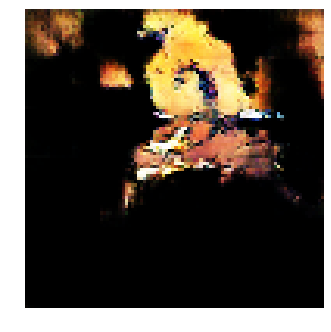


Epoch: 30940, D: -5.576, G: 3.566
Epoch: 30941, D: -7.482, G: 4.51
Epoch: 30942, D: -6.169, G: 4.519
Epoch: 30943, D: -6.375, G: 3.063
Epoch: 30944, D: -4.662, G: 2.498
Epoch: 30945, D: -6.081, G: 2.591
Epoch: 30946, D: -5.613, G: 2.672
Epoch: 30947, D: -6.653, G: 3.806
Epoch: 30948, D: -5.144, G: 3.015
Epoch: 30949, D: -6.388, G: 2.343
Epoch: 30950, D: -5.571, G: 3.929
Epoch: 30951, D: -6.341, G: 3.403
Epoch: 30952, D: -7.749, G: 2.931
Epoch: 30953, D: -5.135, G: 3.354
Epoch: 30954, D: -6.051, G: 4.953
Epoch: 30955, D: -7.614, G: 3.198
Epoch: 30956, D: -6.645, G: 4.831
Epoch: 30957, D: -4.905, G: 4.109
Epoch: 30958, D: -5.931, G: 3.226
Epoch: 30959, D: -7.817, G: 3.724


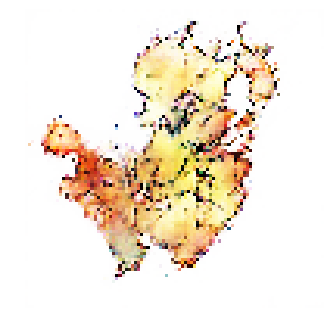


Epoch: 30960, D: -4.861, G: 3.332
Epoch: 30961, D: -5.978, G: 4.486
Epoch: 30962, D: -6.201, G: 4.395
Epoch: 30963, D: -6.94, G: 4.255
Epoch: 30964, D: -5.858, G: 4.363
Epoch: 30965, D: -6.161, G: 4.305
Epoch: 30966, D: -6.303, G: 2.409
Epoch: 30967, D: -6.159, G: 5.61
Epoch: 30968, D: -6.75, G: 4.504
Epoch: 30969, D: -5.552, G: 2.765
Epoch: 30970, D: -7.764, G: 2.793
Epoch: 30971, D: -6.115, G: 4.122
Epoch: 30972, D: -6.315, G: 4.118
Epoch: 30973, D: -5.9, G: 3.739
Epoch: 30974, D: -7.954, G: 3.827
Epoch: 30975, D: -5.401, G: 3.58
Epoch: 30976, D: -4.312, G: 3.33
Epoch: 30977, D: -6.092, G: 3.224
Epoch: 30978, D: -7.609, G: 1.425
Epoch: 30979, D: -6.681, G: 1.897


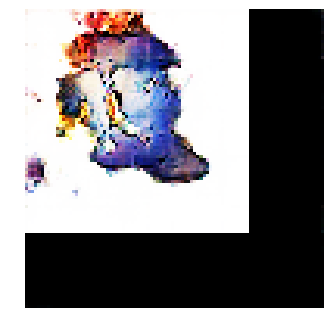


Epoch: 30980, D: -6.965, G: 2.573
Epoch: 30981, D: -4.093, G: 3.863
Epoch: 30982, D: -6.363, G: 4.401
Epoch: 30983, D: -7.151, G: 4.725
Epoch: 30984, D: -5.891, G: 2.783
Epoch: 30985, D: -5.025, G: 3.065
Epoch: 30986, D: -6.519, G: 4.351
Epoch: 30987, D: -5.081, G: 4.476
Epoch: 30988, D: -6.369, G: 2.661
Epoch: 30989, D: -5.813, G: 4.614
Epoch: 30990, D: -5.828, G: 4.275
Epoch: 30991, D: -5.185, G: 4.226
Epoch: 30992, D: -6.324, G: 3.78
Epoch: 30993, D: -6.842, G: 3.62
Epoch: 30994, D: -7.507, G: 4.326
Epoch: 30995, D: -4.843, G: 4.271
Epoch: 30996, D: -6.576, G: 5.358
Epoch: 30997, D: -7.622, G: 4.144
Epoch: 30998, D: -6.887, G: 4.681
Epoch: 30999, D: -5.794, G: 5.365


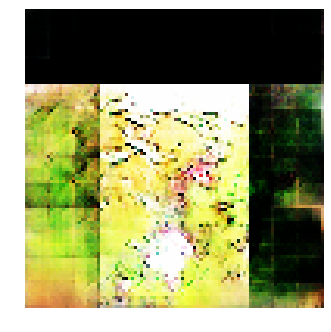


Epoch: 31000, D: -6.577, G: 5.431
Epoch: 31001, D: -5.248, G: 4.106
Epoch: 31002, D: -5.118, G: 5.519
Epoch: 31003, D: -6.27, G: 4.226
Epoch: 31004, D: -5.61, G: 6.479
Epoch: 31005, D: -6.561, G: 5.655
Epoch: 31006, D: -5.315, G: 5.678
Epoch: 31007, D: -5.01, G: 5.565
Epoch: 31008, D: -5.351, G: 4.558
Epoch: 31009, D: -5.264, G: 6.099
Epoch: 31010, D: -6.261, G: 3.322
Epoch: 31011, D: -5.938, G: 4.358
Epoch: 31012, D: -5.956, G: 3.432
Epoch: 31013, D: -5.559, G: 3.232
Epoch: 31014, D: -6.701, G: 4.437
Epoch: 31015, D: -6.426, G: 4.834
Epoch: 31016, D: -6.722, G: 4.641
Epoch: 31017, D: -4.757, G: 2.886
Epoch: 31018, D: -4.889, G: 3.564
Epoch: 31019, D: -5.959, G: 3.967


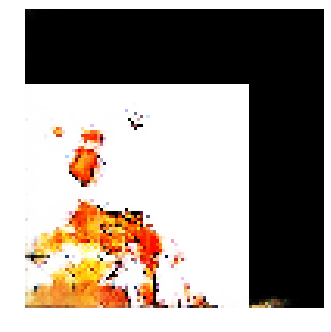


Epoch: 31020, D: -7.309, G: 2.641
Epoch: 31021, D: -6.182, G: 2.519
Epoch: 31022, D: -6.74, G: 4.127
Epoch: 31023, D: -6.972, G: 4.102
Epoch: 31024, D: -4.592, G: 5.006
Epoch: 31025, D: -6.309, G: 5.11
Epoch: 31026, D: -6.573, G: 4.548
Epoch: 31027, D: -6.347, G: 3.962
Epoch: 31028, D: -5.7, G: 5.647
Epoch: 31029, D: -6.951, G: 4.719
Epoch: 31030, D: -7.45, G: 5.677
Epoch: 31031, D: -5.358, G: 4.322
Epoch: 31032, D: -4.38, G: 3.456
Epoch: 31033, D: -7.061, G: 5.257
Epoch: 31034, D: -5.04, G: 2.288
Epoch: 31035, D: -5.194, G: 2.436
Epoch: 31036, D: -5.713, G: 4.278
Epoch: 31037, D: -7.101, G: 4.168
Epoch: 31038, D: -6.167, G: 3.635
Epoch: 31039, D: -6.173, G: 4.34


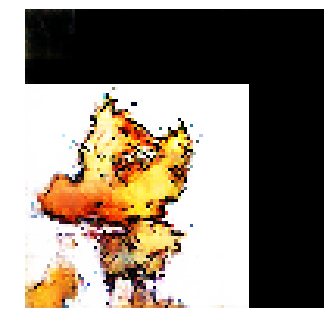


Epoch: 31040, D: -5.407, G: 3.689
Epoch: 31041, D: -6.599, G: 4.479
Epoch: 31042, D: -5.777, G: 3.85
Epoch: 31043, D: -5.467, G: 3.164
Epoch: 31044, D: -6.962, G: 2.942
Epoch: 31045, D: -6.058, G: 3.692
Epoch: 31046, D: -6.478, G: 1.707
Epoch: 31047, D: -6.12, G: 3.457
Epoch: 31048, D: -5.744, G: 3.292
Epoch: 31049, D: -5.716, G: 3.496
Epoch: 31050, D: -6.079, G: 4.105
Epoch: 31051, D: -6.204, G: 5.421
Epoch: 31052, D: -6.398, G: 4.491
Epoch: 31053, D: -6.533, G: 5.399
Epoch: 31054, D: -5.942, G: 5.294
Epoch: 31055, D: -5.885, G: 3.555
Epoch: 31056, D: -5.543, G: 5.156
Epoch: 31057, D: -6.762, G: 4.332
Epoch: 31058, D: -7.342, G: 5.062
Epoch: 31059, D: -6.456, G: 5.212


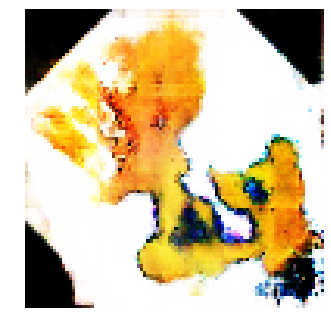


Epoch: 31060, D: -5.801, G: 5.785
Epoch: 31061, D: -5.827, G: 3.253
Epoch: 31062, D: -6.245, G: 3.28
Epoch: 31063, D: -7.337, G: 2.649
Epoch: 31064, D: -6.108, G: 2.483
Epoch: 31065, D: -5.716, G: 2.506
Epoch: 31066, D: -5.533, G: 4.097
Epoch: 31067, D: -7.47, G: 1.984
Epoch: 31068, D: -5.878, G: 4.092
Epoch: 31069, D: -5.39, G: 4.513
Epoch: 31070, D: -6.129, G: 2.505
Epoch: 31071, D: -6.615, G: 3.923
Epoch: 31072, D: -6.243, G: 3.15
Epoch: 31073, D: -6.164, G: 3.243
Epoch: 31074, D: -7.363, G: 3.389
Epoch: 31075, D: -5.794, G: 4.411
Epoch: 31076, D: -7.401, G: 4.695
Epoch: 31077, D: -6.237, G: 4.149
Epoch: 31078, D: -6.412, G: 4.69
Epoch: 31079, D: -5.137, G: 3.446


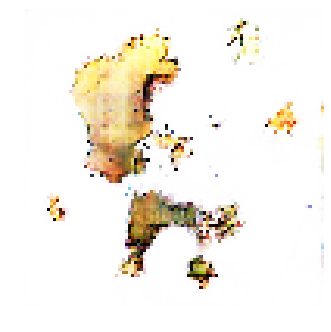


Epoch: 31080, D: -5.88, G: 3.504
Epoch: 31081, D: -6.27, G: 3.481
Epoch: 31082, D: -6.433, G: 5.647
Epoch: 31083, D: -5.756, G: 3.085
Epoch: 31084, D: -8.047, G: 3.478
Epoch: 31085, D: -6.327, G: 4.896
Epoch: 31086, D: -6.343, G: 3.244
Epoch: 31087, D: -6.459, G: 3.675
Epoch: 31088, D: -6.327, G: 4.793
Epoch: 31089, D: -5.167, G: 2.396
Epoch: 31090, D: -4.938, G: 5.04
Epoch: 31091, D: -6.763, G: 3.547
Epoch: 31092, D: -5.881, G: 3.246
Epoch: 31093, D: -5.732, G: 4.829
Epoch: 31094, D: -5.143, G: 3.467
Epoch: 31095, D: -6.38, G: 4.093
Epoch: 31096, D: -5.081, G: 4.225
Epoch: 31097, D: -8.487, G: 5.246
Epoch: 31098, D: -6.64, G: 3.797
Epoch: 31099, D: -4.514, G: 2.692


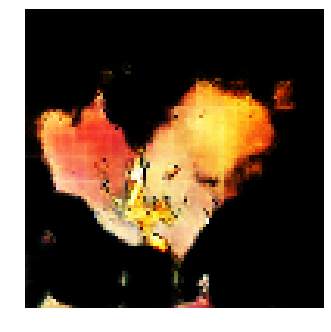


Epoch: 31100, D: -5.732, G: 4.764
Epoch: 31101, D: -6.4, G: 4.563
Epoch: 31102, D: -6.281, G: 4.134
Epoch: 31103, D: -5.033, G: 4.331
Epoch: 31104, D: -8.288, G: 5.036
Epoch: 31105, D: -5.153, G: 4.383
Epoch: 31106, D: -6.852, G: 5.59
Epoch: 31107, D: -6.393, G: 4.094
Epoch: 31108, D: -5.424, G: 6.071
Epoch: 31109, D: -6.627, G: 5.122
Epoch: 31110, D: -6.187, G: 2.554
Epoch: 31111, D: -7.586, G: 3.969
Epoch: 31112, D: -6.236, G: 2.991
Epoch: 31113, D: -4.832, G: 2.758
Epoch: 31114, D: -5.808, G: 2.637
Epoch: 31115, D: -6.626, G: 2.996
Epoch: 31116, D: -5.806, G: 3.606
Epoch: 31117, D: -5.62, G: 5.212
Epoch: 31118, D: -6.674, G: 5.313
Epoch: 31119, D: -7.735, G: 4.06


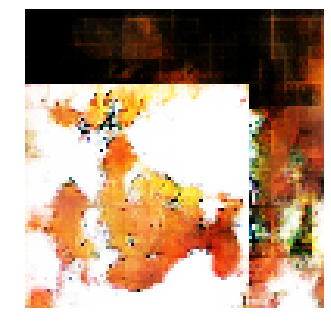


Epoch: 31120, D: -6.153, G: 2.66
Epoch: 31121, D: -6.647, G: 3.234
Epoch: 31122, D: -7.746, G: 5.312
Epoch: 31123, D: -7.101, G: 7.729
Epoch: 31124, D: -6.497, G: 4.996
Epoch: 31125, D: -6.476, G: 5.232
Epoch: 31126, D: -4.89, G: 4.995
Epoch: 31127, D: -5.699, G: 4.486
Epoch: 31128, D: -6.094, G: 4.022
Epoch: 31129, D: -3.923, G: 2.886
Epoch: 31130, D: -6.609, G: 5.202
Epoch: 31131, D: -5.369, G: 2.703
Epoch: 31132, D: -4.844, G: 3.108
Epoch: 31133, D: -6.222, G: 3.818
Epoch: 31134, D: -5.71, G: 4.009
Epoch: 31135, D: -6.421, G: 2.692
Epoch: 31136, D: -5.401, G: 4.597
Epoch: 31137, D: -7.56, G: 4.88
Epoch: 31138, D: -5.483, G: 4.881
Epoch: 31139, D: -4.622, G: 5.815


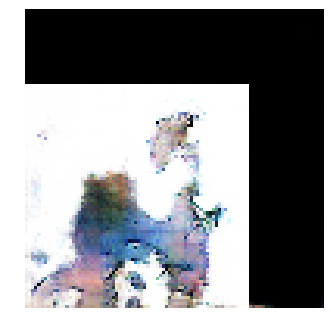


Epoch: 31140, D: -5.291, G: 4.223
Epoch: 31141, D: -7.143, G: 3.872
Epoch: 31142, D: -8.098, G: 4.851
Epoch: 31143, D: -5.679, G: 2.948
Epoch: 31144, D: -6.809, G: 5.48
Epoch: 31145, D: -7.296, G: 1.918
Epoch: 31146, D: -4.745, G: 2.622
Epoch: 31147, D: -8.002, G: 3.171
Epoch: 31148, D: -5.42, G: 1.506
Epoch: 31149, D: -5.56, G: 2.43
Epoch: 31150, D: -8.024, G: 1.216
Epoch: 31151, D: -6.651, G: 3.217
Epoch: 31152, D: -6.687, G: 3.448
Epoch: 31153, D: -5.292, G: 3.643
Epoch: 31154, D: -6.819, G: 3.245
Epoch: 31155, D: -9.027, G: 3.525
Epoch: 31156, D: -7.64, G: 3.823
Epoch: 31157, D: -5.677, G: 5.357
Epoch: 31158, D: -6.224, G: 4.517
Epoch: 31159, D: -7.586, G: 3.725


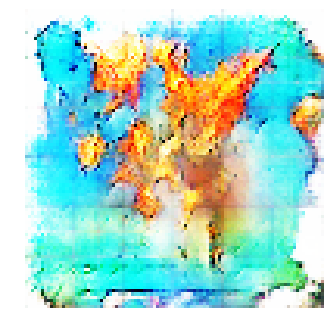


Epoch: 31160, D: -5.389, G: 4.223
Epoch: 31161, D: -5.378, G: 4.722
Epoch: 31162, D: -3.938, G: 4.8
Epoch: 31163, D: -7.139, G: 4.052
Epoch: 31164, D: -6.049, G: 2.889
Epoch: 31165, D: -6.851, G: 5.952
Epoch: 31166, D: -7.085, G: 4.393
Epoch: 31167, D: -5.574, G: 3.828
Epoch: 31168, D: -6.044, G: 3.708
Epoch: 31169, D: -5.063, G: 5.177
Epoch: 31170, D: -7.263, G: 3.732
Epoch: 31171, D: -4.897, G: 3.169
Epoch: 31172, D: -6.062, G: 4.915
Epoch: 31173, D: -5.777, G: 5.723
Epoch: 31174, D: -5.982, G: 5.377
Epoch: 31175, D: -6.452, G: 4.742
Epoch: 31176, D: -7.488, G: 1.291
Epoch: 31177, D: -6.308, G: 3.08
Epoch: 31178, D: -4.455, G: 3.741
Epoch: 31179, D: -7.488, G: 3.054


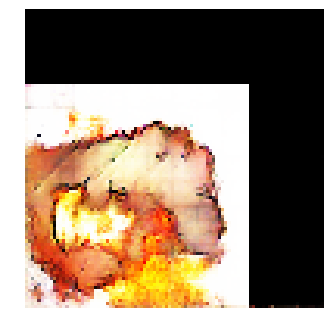


Epoch: 31180, D: -6.172, G: 3.785
Epoch: 31181, D: -5.964, G: 4.125
Epoch: 31182, D: -6.871, G: 5.11
Epoch: 31183, D: -6.188, G: 3.981
Epoch: 31184, D: -6.648, G: 5.382
Epoch: 31185, D: -4.811, G: 6.068
Epoch: 31186, D: -7.451, G: 5.765
Epoch: 31187, D: -6.015, G: 3.541
Epoch: 31188, D: -6.661, G: 5.819
Epoch: 31189, D: -5.372, G: 4.662
Epoch: 31190, D: -5.589, G: 5.336
Epoch: 31191, D: -6.782, G: 2.378
Epoch: 31192, D: -6.735, G: 1.64
Epoch: 31193, D: -6.461, G: 6.104
Epoch: 31194, D: -6.835, G: 2.435
Epoch: 31195, D: -5.214, G: 4.15
Epoch: 31196, D: -4.805, G: 3.069
Epoch: 31197, D: -5.069, G: 1.752
Epoch: 31198, D: -5.886, G: 3.927
Epoch: 31199, D: -5.31, G: 4.263


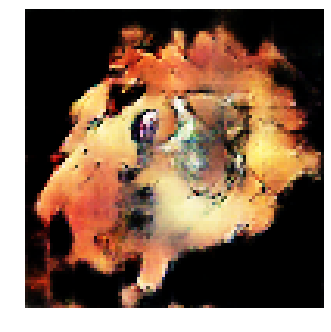


Epoch: 31200, D: -5.952, G: 6.159
Epoch: 31201, D: -5.94, G: 5.113
Epoch: 31202, D: -5.201, G: 4.446
Epoch: 31203, D: -6.657, G: 5.304
Epoch: 31204, D: -6.346, G: 3.62
Epoch: 31205, D: -7.302, G: 2.776
Epoch: 31206, D: -5.769, G: 2.303
Epoch: 31207, D: -6.005, G: 2.328
Epoch: 31208, D: -6.539, G: 1.989
Epoch: 31209, D: -7.193, G: 2.388
Epoch: 31210, D: -6.88, G: 3.73
Epoch: 31211, D: -5.717, G: 4.452
Epoch: 31212, D: -5.266, G: 2.991
Epoch: 31213, D: -5.304, G: 4.082
Epoch: 31214, D: -5.563, G: 5.358
Epoch: 31215, D: -7.507, G: 3.714
Epoch: 31216, D: -5.47, G: 3.498
Epoch: 31217, D: -5.63, G: 5.345
Epoch: 31218, D: -6.249, G: 2.149
Epoch: 31219, D: -6.696, G: 2.775


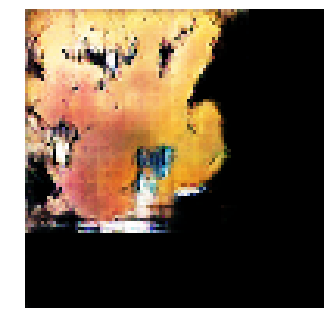


Epoch: 31220, D: -7.281, G: 3.376
Epoch: 31221, D: -7.131, G: 2.495
Epoch: 31222, D: -6.493, G: 4.261
Epoch: 31223, D: -6.613, G: 2.879
Epoch: 31224, D: -7.313, G: 3.487
Epoch: 31225, D: -5.702, G: 5.426
Epoch: 31226, D: -5.826, G: 6.212
Epoch: 31227, D: -6.33, G: 3.829
Epoch: 31228, D: -6.753, G: 3.349
Epoch: 31229, D: -6.89, G: 4.677
Epoch: 31230, D: -6.119, G: 3.533
Epoch: 31231, D: -5.85, G: 2.946
Epoch: 31232, D: -5.808, G: 3.316
Epoch: 31233, D: -4.891, G: 4.857
Epoch: 31234, D: -6.986, G: 4.41
Epoch: 31235, D: -6.226, G: 3.575
Epoch: 31236, D: -4.943, G: 1.517
Epoch: 31237, D: -5.455, G: 4.192
Epoch: 31238, D: -6.667, G: 2.805
Epoch: 31239, D: -4.718, G: 3.887


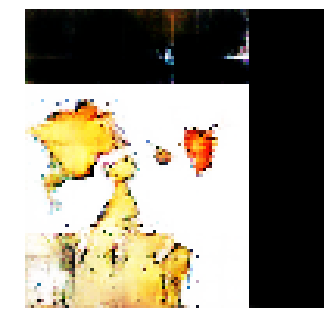


Epoch: 31240, D: -7.098, G: 3.04
Epoch: 31241, D: -5.855, G: 2.286
Epoch: 31242, D: -5.766, G: 2.831
Epoch: 31243, D: -3.763, G: 2.98
Epoch: 31244, D: -5.009, G: 2.921
Epoch: 31245, D: -6.062, G: 3.104
Epoch: 31246, D: -5.793, G: 4.466
Epoch: 31247, D: -6.85, G: 2.823
Epoch: 31248, D: -6.264, G: 2.925
Epoch: 31249, D: -5.76, G: 5.139
Epoch: 31250, D: -6.043, G: 4.73
Epoch: 31251, D: -5.88, G: 4.053
Epoch: 31252, D: -7.215, G: 4.13
Epoch: 31253, D: -5.857, G: 4.553
Epoch: 31254, D: -5.021, G: 6.078
Epoch: 31255, D: -5.253, G: 1.478
Epoch: 31256, D: -6.547, G: 2.937
Epoch: 31257, D: -6.559, G: 1.793
Epoch: 31258, D: -6.478, G: 3.778
Epoch: 31259, D: -6.939, G: 4.014


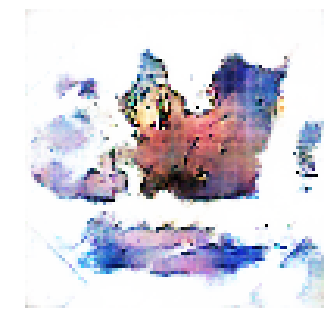


Epoch: 31260, D: -6.542, G: 4.137
Epoch: 31261, D: -5.85, G: 3.367
Epoch: 31262, D: -6.605, G: 4.851
Epoch: 31263, D: -5.975, G: 4.863
Epoch: 31264, D: -5.642, G: 2.713
Epoch: 31265, D: -7.283, G: 3.53
Epoch: 31266, D: -5.802, G: 3.965
Epoch: 31267, D: -7.214, G: 5.195
Epoch: 31268, D: -7.453, G: 3.928
Epoch: 31269, D: -7.028, G: 3.527
Epoch: 31270, D: -7.975, G: 4.509
Epoch: 31271, D: -5.131, G: 3.698
Epoch: 31272, D: -5.986, G: 4.019
Epoch: 31273, D: -4.26, G: 4.561
Epoch: 31274, D: -6.386, G: 5.693
Epoch: 31275, D: -6.015, G: 3.252
Epoch: 31276, D: -6.18, G: 4.177
Epoch: 31277, D: -6.314, G: 4.344
Epoch: 31278, D: -7.768, G: 3.068
Epoch: 31279, D: -5.463, G: 4.78


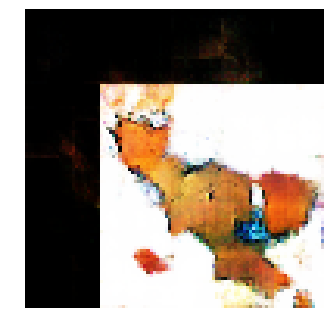


Epoch: 31280, D: -6.045, G: 4.144
Epoch: 31281, D: -5.332, G: 4.601
Epoch: 31282, D: -6.48, G: 2.544
Epoch: 31283, D: -5.957, G: 5.078
Epoch: 31284, D: -5.291, G: 4.619
Epoch: 31285, D: -5.745, G: 3.055
Epoch: 31286, D: -6.175, G: 3.586
Epoch: 31287, D: -6.022, G: 2.969
Epoch: 31288, D: -4.964, G: 3.097
Epoch: 31289, D: -5.351, G: 4.039
Epoch: 31290, D: -6.29, G: 2.417
Epoch: 31291, D: -6.659, G: 4.97
Epoch: 31292, D: -5.796, G: 4.774
Epoch: 31293, D: -4.965, G: 1.78
Epoch: 31294, D: -7.024, G: 3.204
Epoch: 31295, D: -6.726, G: 3.906
Epoch: 31296, D: -6.331, G: 3.542
Epoch: 31297, D: -5.936, G: 4.387
Epoch: 31298, D: -5.368, G: 5.395
Epoch: 31299, D: -4.874, G: 4.652


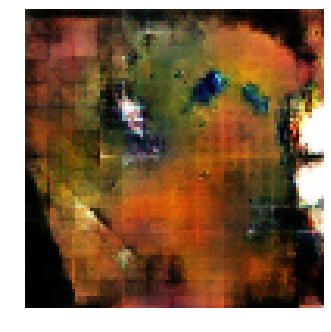


Epoch: 31300, D: -5.557, G: 3.149
Epoch: 31301, D: -6.053, G: 5.444
Epoch: 31302, D: -5.846, G: 4.193
Epoch: 31303, D: -6.898, G: 2.804
Epoch: 31304, D: -7.21, G: 5.138
Epoch: 31305, D: -5.729, G: 3.769
Epoch: 31306, D: -4.96, G: 6.264
Epoch: 31307, D: -6.898, G: 4.927
Epoch: 31308, D: -7.338, G: 4.92
Epoch: 31309, D: -5.71, G: 3.019
Epoch: 31310, D: -5.592, G: 6.002
Epoch: 31311, D: -6.278, G: 3.042
Epoch: 31312, D: -6.423, G: 3.362
Epoch: 31313, D: -6.695, G: 2.466
Epoch: 31314, D: -6.942, G: 2.539
Epoch: 31315, D: -6.647, G: 3.826
Epoch: 31316, D: -6.367, G: 3.898
Epoch: 31317, D: -5.372, G: 2.285
Epoch: 31318, D: -6.087, G: 4.267
Epoch: 31319, D: -6.238, G: 3.341


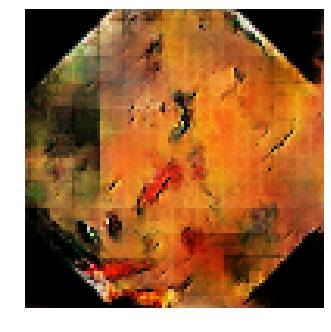


Epoch: 31320, D: -5.619, G: 1.764
Epoch: 31321, D: -6.292, G: 3.526
Epoch: 31322, D: -8.031, G: 3.912
Epoch: 31323, D: -5.846, G: 2.838
Epoch: 31324, D: -5.925, G: 2.723
Epoch: 31325, D: -5.07, G: 3.415
Epoch: 31326, D: -5.528, G: 3.617
Epoch: 31327, D: -6.043, G: 3.062
Epoch: 31328, D: -6.906, G: 4.147
Epoch: 31329, D: -6.251, G: 1.674
Epoch: 31330, D: -5.989, G: 5.31
Epoch: 31331, D: -6.854, G: 4.273
Epoch: 31332, D: -5.113, G: 5.915
Epoch: 31333, D: -7.037, G: 6.342
Epoch: 31334, D: -7.822, G: 4.304
Epoch: 31335, D: -5.631, G: 3.146
Epoch: 31336, D: -5.624, G: 3.975
Epoch: 31337, D: -6.549, G: 5.396
Epoch: 31338, D: -5.78, G: 5.992
Epoch: 31339, D: -4.748, G: 3.718


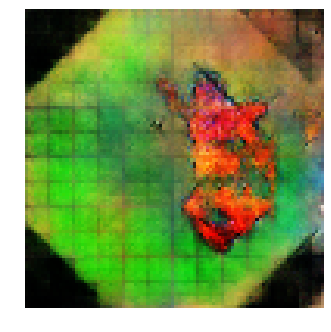


Epoch: 31340, D: -5.71, G: 4.454
Epoch: 31341, D: -7.299, G: 4.499
Epoch: 31342, D: -6.347, G: 2.581
Epoch: 31343, D: -5.424, G: 5.038
Epoch: 31344, D: -5.952, G: 3.541
Epoch: 31345, D: -5.053, G: 2.333
Epoch: 31346, D: -6.02, G: 5.406
Epoch: 31347, D: -7.193, G: 4.977
Epoch: 31348, D: -6.712, G: 5.0
Epoch: 31349, D: -7.563, G: 2.344
Epoch: 31350, D: -5.15, G: 1.816
Epoch: 31351, D: -6.455, G: 2.389
Epoch: 31352, D: -6.917, G: 3.086
Epoch: 31353, D: -5.702, G: 2.092
Epoch: 31354, D: -5.172, G: 2.76
Epoch: 31355, D: -5.801, G: 2.594
Epoch: 31356, D: -6.174, G: 3.871
Epoch: 31357, D: -6.195, G: 3.431
Epoch: 31358, D: -6.679, G: 3.339
Epoch: 31359, D: -6.384, G: 2.774


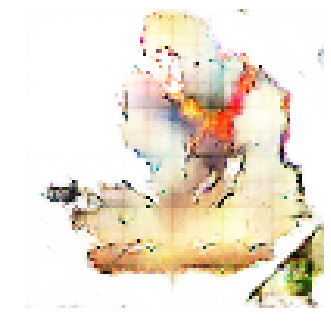


Epoch: 31360, D: -5.173, G: 3.554
Epoch: 31361, D: -6.938, G: 3.444
Epoch: 31362, D: -5.416, G: 3.07
Epoch: 31363, D: -7.071, G: 4.724
Epoch: 31364, D: -7.557, G: 2.486
Epoch: 31365, D: -5.897, G: 2.662
Epoch: 31366, D: -6.533, G: 4.906
Epoch: 31367, D: -6.949, G: 4.784
Epoch: 31368, D: -6.187, G: 3.234
Epoch: 31369, D: -5.443, G: 5.53
Epoch: 31370, D: -6.309, G: 2.883
Epoch: 31371, D: -5.697, G: 4.713
Epoch: 31372, D: -5.889, G: 6.798
Epoch: 31373, D: -5.982, G: 5.802
Epoch: 31374, D: -5.336, G: 3.74
Epoch: 31375, D: -5.339, G: 4.633
Epoch: 31376, D: -7.076, G: 4.793
Epoch: 31377, D: -8.281, G: 3.738
Epoch: 31378, D: -5.923, G: 2.324
Epoch: 31379, D: -5.8, G: 4.65


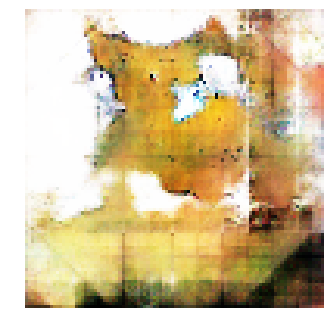


Epoch: 31380, D: -5.856, G: 3.348
Epoch: 31381, D: -7.167, G: 3.678
Epoch: 31382, D: -6.732, G: 4.56
Epoch: 31383, D: -5.11, G: 4.494
Epoch: 31384, D: -5.876, G: 3.604
Epoch: 31385, D: -5.978, G: 4.835
Epoch: 31386, D: -6.485, G: 3.116
Epoch: 31387, D: -5.602, G: 5.678
Epoch: 31388, D: -7.181, G: 4.848
Epoch: 31389, D: -6.009, G: 4.934
Epoch: 31390, D: -5.732, G: 4.049
Epoch: 31391, D: -7.097, G: 4.435
Epoch: 31392, D: -4.674, G: 3.127
Epoch: 31393, D: -5.823, G: 2.935
Epoch: 31394, D: -5.686, G: 3.712
Epoch: 31395, D: -6.492, G: 3.101
Epoch: 31396, D: -5.963, G: 4.66
Epoch: 31397, D: -7.103, G: 6.214
Epoch: 31398, D: -5.489, G: 3.966
Epoch: 31399, D: -6.15, G: 6.039


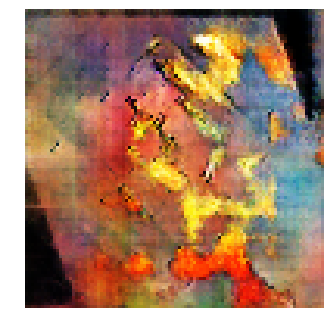


Epoch: 31400, D: -6.182, G: 4.514
Epoch: 31401, D: -6.036, G: 2.36
Epoch: 31402, D: -6.026, G: 3.403
Epoch: 31403, D: -5.481, G: 4.542
Epoch: 31404, D: -6.118, G: 4.672
Epoch: 31405, D: -6.723, G: 4.026
Epoch: 31406, D: -4.65, G: 3.147
Epoch: 31407, D: -6.237, G: 2.808
Epoch: 31408, D: -7.116, G: 3.931
Epoch: 31409, D: -7.261, G: 0.7875
Epoch: 31410, D: -7.211, G: 2.033
Epoch: 31411, D: -4.981, G: 2.058
Epoch: 31412, D: -6.391, G: 3.563
Epoch: 31413, D: -4.978, G: 4.1
Epoch: 31414, D: -6.727, G: 3.367
Epoch: 31415, D: -6.448, G: 3.974
Epoch: 31416, D: -4.619, G: 1.709
Epoch: 31417, D: -4.634, G: 3.035
Epoch: 31418, D: -5.504, G: 4.096
Epoch: 31419, D: -6.082, G: 3.593


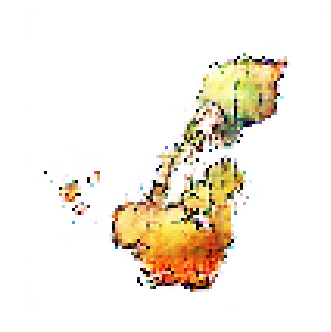


Epoch: 31420, D: -7.435, G: 3.765
Epoch: 31421, D: -5.955, G: 4.663
Epoch: 31422, D: -7.212, G: 2.333
Epoch: 31423, D: -5.339, G: 1.58
Epoch: 31424, D: -8.101, G: 5.847
Epoch: 31425, D: -7.637, G: 4.201
Epoch: 31426, D: -6.335, G: 4.542
Epoch: 31427, D: -6.373, G: 5.63
Epoch: 31428, D: -6.247, G: 3.962
Epoch: 31429, D: -6.663, G: 3.909
Epoch: 31430, D: -6.482, G: 3.655
Epoch: 31431, D: -6.352, G: 3.971
Epoch: 31432, D: -6.585, G: 5.457
Epoch: 31433, D: -6.549, G: 4.591
Epoch: 31434, D: -5.101, G: 5.108
Epoch: 31435, D: -6.557, G: 4.263
Epoch: 31436, D: -7.625, G: 5.367
Epoch: 31437, D: -6.534, G: 5.603
Epoch: 31438, D: -6.178, G: 5.483
Epoch: 31439, D: -6.22, G: 4.057


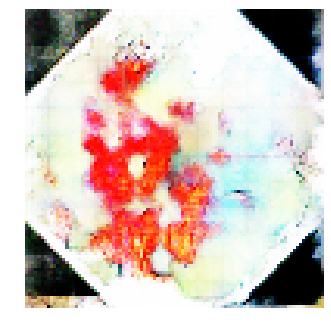


Epoch: 31440, D: -5.669, G: 4.327
Epoch: 31441, D: -6.153, G: 5.158
Epoch: 31442, D: -5.173, G: 4.522
Epoch: 31443, D: -6.642, G: 4.223
Epoch: 31444, D: -5.944, G: 3.307
Epoch: 31445, D: -7.088, G: 4.595
Epoch: 31446, D: -7.108, G: 2.351
Epoch: 31447, D: -6.468, G: 4.638
Epoch: 31448, D: -5.68, G: 3.964
Epoch: 31449, D: -4.438, G: 4.361
Epoch: 31450, D: -6.838, G: 5.561
Epoch: 31451, D: -5.385, G: 4.074
Epoch: 31452, D: -6.126, G: 1.561
Epoch: 31453, D: -6.807, G: 3.662
Epoch: 31454, D: -5.881, G: 4.266
Epoch: 31455, D: -6.802, G: 4.395
Epoch: 31456, D: -5.238, G: 5.888
Epoch: 31457, D: -5.739, G: 4.971
Epoch: 31458, D: -5.065, G: 4.373
Epoch: 31459, D: -5.334, G: 4.157


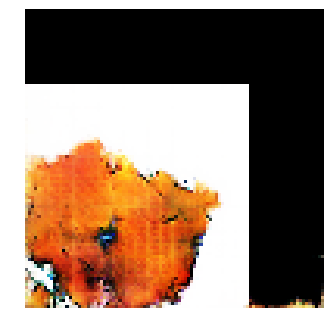


Epoch: 31460, D: -6.473, G: 3.069
Epoch: 31461, D: -6.072, G: 3.827
Epoch: 31462, D: -5.471, G: 4.217
Epoch: 31463, D: -5.84, G: 4.147
Epoch: 31464, D: -5.867, G: 2.854
Epoch: 31465, D: -5.791, G: 4.403
Epoch: 31466, D: -6.462, G: 4.333
Epoch: 31467, D: -5.334, G: 4.47
Epoch: 31468, D: -5.764, G: 3.515
Epoch: 31469, D: -5.494, G: 3.758
Epoch: 31470, D: -5.997, G: 5.35
Epoch: 31471, D: -8.178, G: 4.569
Epoch: 31472, D: -6.435, G: 6.046
Epoch: 31473, D: -5.032, G: 2.673
Epoch: 31474, D: -5.826, G: 2.475
Epoch: 31475, D: -5.992, G: 3.266
Epoch: 31476, D: -5.764, G: 3.921
Epoch: 31477, D: -5.118, G: 4.622
Epoch: 31478, D: -7.293, G: 4.454
Epoch: 31479, D: -6.653, G: 2.386


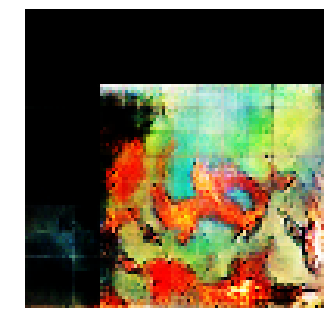


Epoch: 31480, D: -5.68, G: 4.129
Epoch: 31481, D: -5.925, G: 5.323
Epoch: 31482, D: -6.841, G: 3.921
Epoch: 31483, D: -5.812, G: 4.18
Epoch: 31484, D: -8.153, G: 5.528
Epoch: 31485, D: -6.047, G: 2.658
Epoch: 31486, D: -5.73, G: 2.456
Epoch: 31487, D: -5.302, G: 3.109
Epoch: 31488, D: -4.849, G: 2.579
Epoch: 31489, D: -5.089, G: 4.578
Epoch: 31490, D: -5.005, G: 4.497
Epoch: 31491, D: -7.096, G: 4.089
Epoch: 31492, D: -7.161, G: 1.627
Epoch: 31493, D: -6.526, G: 3.181
Epoch: 31494, D: -6.259, G: 3.973
Epoch: 31495, D: -5.661, G: 3.255
Epoch: 31496, D: -4.918, G: 2.628
Epoch: 31497, D: -5.156, G: 5.915
Epoch: 31498, D: -6.558, G: 5.138
Epoch: 31499, D: -4.94, G: 5.818


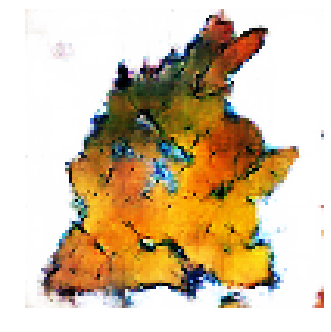


Epoch: 31500, D: -6.247, G: 3.249
Epoch: 31501, D: -6.262, G: 3.767
Epoch: 31502, D: -7.285, G: 4.886
Epoch: 31503, D: -5.187, G: 4.494
Epoch: 31504, D: -5.899, G: 4.105
Epoch: 31505, D: -6.782, G: 5.064
Epoch: 31506, D: -6.381, G: 5.827
Epoch: 31507, D: -6.108, G: 3.895
Epoch: 31508, D: -7.052, G: 2.566
Epoch: 31509, D: -5.782, G: 3.16
Epoch: 31510, D: -6.98, G: 4.215
Epoch: 31511, D: -6.377, G: 5.066
Epoch: 31512, D: -7.975, G: 5.552
Epoch: 31513, D: -4.782, G: 5.328
Epoch: 31514, D: -5.447, G: 4.483
Epoch: 31515, D: -5.361, G: 2.78
Epoch: 31516, D: -6.616, G: 4.495
Epoch: 31517, D: -5.928, G: 3.181
Epoch: 31518, D: -6.906, G: 3.498
Epoch: 31519, D: -6.926, G: 1.548


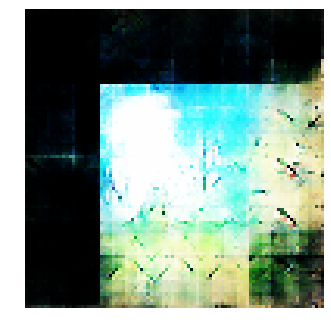


Epoch: 31520, D: -6.926, G: 1.375
Epoch: 31521, D: -5.514, G: 3.336
Epoch: 31522, D: -7.181, G: 5.04
Epoch: 31523, D: -7.767, G: 2.703
Epoch: 31524, D: -5.679, G: 6.762
Epoch: 31525, D: -6.878, G: 5.393
Epoch: 31526, D: -5.237, G: 5.237
Epoch: 31527, D: -6.197, G: 5.024
Epoch: 31528, D: -5.899, G: 5.426
Epoch: 31529, D: -5.461, G: 5.341
Epoch: 31530, D: -8.034, G: 5.084
Epoch: 31531, D: -7.472, G: 4.591
Epoch: 31532, D: -6.688, G: 5.323
Epoch: 31533, D: -5.515, G: 3.534
Epoch: 31534, D: -6.86, G: 3.286
Epoch: 31535, D: -4.91, G: 5.628
Epoch: 31536, D: -5.281, G: 4.535
Epoch: 31537, D: -7.756, G: 2.871
Epoch: 31538, D: -6.605, G: 1.198
Epoch: 31539, D: -5.975, G: 4.506


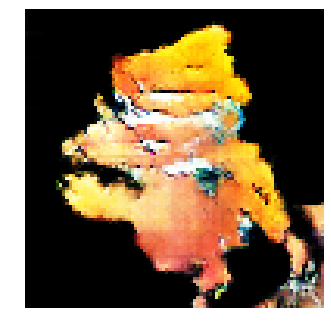


Epoch: 31540, D: -5.689, G: 4.441
Epoch: 31541, D: -5.94, G: 3.627
Epoch: 31542, D: -7.119, G: 2.3
Epoch: 31543, D: -6.321, G: 4.728
Epoch: 31544, D: -5.647, G: 3.851
Epoch: 31545, D: -6.504, G: 4.057
Epoch: 31546, D: -5.772, G: 4.206
Epoch: 31547, D: -7.4, G: 2.662
Epoch: 31548, D: -7.249, G: 3.693
Epoch: 31549, D: -5.224, G: 3.843
Epoch: 31550, D: -6.872, G: 2.932
Epoch: 31551, D: -4.839, G: 2.142
Epoch: 31552, D: -6.35, G: 3.063
Epoch: 31553, D: -4.765, G: 5.291
Epoch: 31554, D: -6.325, G: 3.807
Epoch: 31555, D: -5.949, G: 5.387
Epoch: 31556, D: -6.313, G: 3.995
Epoch: 31557, D: -5.55, G: 4.442
Epoch: 31558, D: -8.517, G: 2.458
Epoch: 31559, D: -6.225, G: 1.551


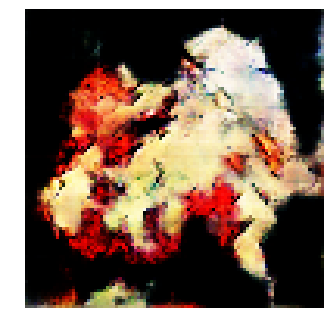


Epoch: 31560, D: -7.013, G: 4.653
Epoch: 31561, D: -6.458, G: 1.88
Epoch: 31562, D: -6.431, G: 5.357
Epoch: 31563, D: -5.472, G: 2.525
Epoch: 31564, D: -6.606, G: 5.947
Epoch: 31565, D: -5.38, G: 3.886
Epoch: 31566, D: -5.711, G: 4.788
Epoch: 31567, D: -5.805, G: 4.898
Epoch: 31568, D: -6.532, G: 3.916
Epoch: 31569, D: -7.328, G: 5.275
Epoch: 31570, D: -6.454, G: 3.075
Epoch: 31571, D: -6.512, G: 4.997
Epoch: 31572, D: -5.76, G: 3.343
Epoch: 31573, D: -6.316, G: 5.176
Epoch: 31574, D: -5.594, G: 5.31
Epoch: 31575, D: -6.411, G: 4.641
Epoch: 31576, D: -6.276, G: 5.006
Epoch: 31577, D: -4.775, G: 5.088
Epoch: 31578, D: -3.952, G: 4.48
Epoch: 31579, D: -5.336, G: 4.833


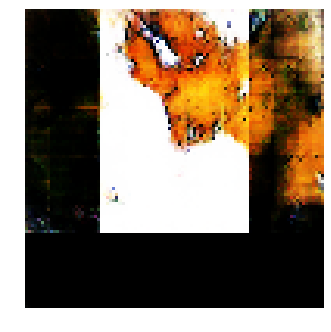


Epoch: 31580, D: -6.988, G: 4.815
Epoch: 31581, D: -6.048, G: 3.881
Epoch: 31582, D: -6.703, G: 4.197
Epoch: 31583, D: -5.754, G: 3.974
Epoch: 31584, D: -4.391, G: 4.352
Epoch: 31585, D: -6.131, G: 4.061
Epoch: 31586, D: -5.824, G: 4.347
Epoch: 31587, D: -5.748, G: 4.498
Epoch: 31588, D: -6.448, G: 3.453
Epoch: 31589, D: -5.869, G: 5.29
Epoch: 31590, D: -5.325, G: 3.672
Epoch: 31591, D: -5.473, G: 4.764
Epoch: 31592, D: -5.63, G: 4.201
Epoch: 31593, D: -6.369, G: 5.679
Epoch: 31594, D: -7.575, G: 3.215
Epoch: 31595, D: -6.356, G: 2.499
Epoch: 31596, D: -7.2, G: 0.907
Epoch: 31597, D: -7.035, G: 3.228
Epoch: 31598, D: -5.887, G: 3.434
Epoch: 31599, D: -6.155, G: 2.576


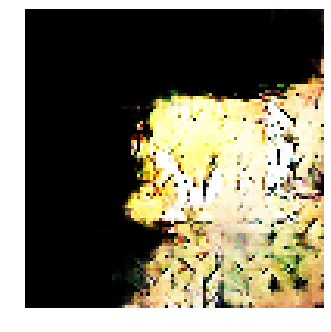


Epoch: 31600, D: -5.667, G: 3.103
Epoch: 31601, D: -5.262, G: 5.364
Epoch: 31602, D: -4.988, G: 3.228
Epoch: 31603, D: -7.7, G: 3.725
Epoch: 31604, D: -5.437, G: 3.604
Epoch: 31605, D: -6.311, G: 4.539
Epoch: 31606, D: -6.339, G: 5.991
Epoch: 31607, D: -7.015, G: 5.621
Epoch: 31608, D: -5.654, G: 4.544
Epoch: 31609, D: -5.717, G: 5.803
Epoch: 31610, D: -5.828, G: 4.326
Epoch: 31611, D: -5.005, G: 5.007
Epoch: 31612, D: -6.727, G: 4.941
Epoch: 31613, D: -6.392, G: 4.344
Epoch: 31614, D: -7.176, G: 3.448
Epoch: 31615, D: -5.484, G: 4.932
Epoch: 31616, D: -6.091, G: 4.49
Epoch: 31617, D: -6.497, G: 4.044
Epoch: 31618, D: -5.901, G: 2.605
Epoch: 31619, D: -5.743, G: 4.381


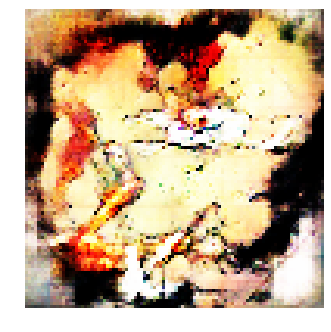


Epoch: 31620, D: -6.271, G: 4.646
Epoch: 31621, D: -5.662, G: 3.569
Epoch: 31622, D: -5.779, G: 4.002
Epoch: 31623, D: -5.925, G: 4.702
Epoch: 31624, D: -6.33, G: 6.401
Epoch: 31625, D: -6.4, G: 4.237
Epoch: 31626, D: -7.117, G: 6.61
Epoch: 31627, D: -7.03, G: 3.711
Epoch: 31628, D: -6.487, G: 3.66
Epoch: 31629, D: -5.057, G: 5.576
Epoch: 31630, D: -7.181, G: 4.329
Epoch: 31631, D: -5.337, G: 3.373
Epoch: 31632, D: -7.977, G: 5.938
Epoch: 31633, D: -5.762, G: 6.347
Epoch: 31634, D: -5.956, G: 2.761
Epoch: 31635, D: 3.339, G: 2.568
Epoch: 31636, D: -6.806, G: 3.881
Epoch: 31637, D: -6.432, G: 3.912
Epoch: 31638, D: -3.257, G: 2.881
Epoch: 31639, D: -6.937, G: 2.616


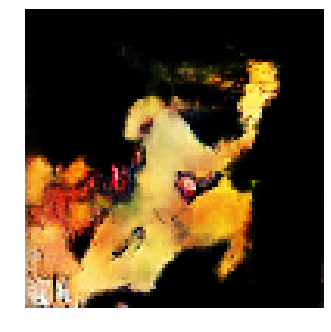


Epoch: 31640, D: -5.393, G: 3.432
Epoch: 31641, D: -6.338, G: 3.167
Epoch: 31642, D: -6.052, G: 3.669
Epoch: 31643, D: -5.306, G: 5.046
Epoch: 31644, D: -6.058, G: 2.959
Epoch: 31645, D: -5.206, G: 1.454
Epoch: 31646, D: -6.931, G: 4.155
Epoch: 31647, D: -5.942, G: 3.295
Epoch: 31648, D: -4.543, G: 5.128
Epoch: 31649, D: -5.885, G: 4.164
Epoch: 31650, D: -5.781, G: 2.358
Epoch: 31651, D: -6.605, G: 2.757
Epoch: 31652, D: -5.458, G: 3.296
Epoch: 31653, D: -6.084, G: 2.871
Epoch: 31654, D: -5.064, G: 2.616
Epoch: 31655, D: -6.803, G: 5.375
Epoch: 31656, D: -7.18, G: 4.955
Epoch: 31657, D: -5.934, G: 5.171
Epoch: 31658, D: -6.835, G: 3.226
Epoch: 31659, D: -5.112, G: 5.974


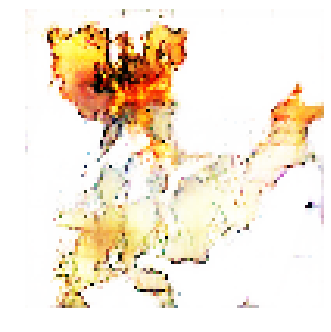


Epoch: 31660, D: -8.318, G: 3.338
Epoch: 31661, D: -7.515, G: 3.399
Epoch: 31662, D: -5.827, G: 4.741
Epoch: 31663, D: -6.787, G: 4.741
Epoch: 31664, D: -6.79, G: 6.252
Epoch: 31665, D: -7.921, G: 7.448
Epoch: 31666, D: -6.955, G: 4.223
Epoch: 31667, D: -6.26, G: 5.683
Epoch: 31668, D: -4.696, G: 6.715
Epoch: 31669, D: -5.766, G: 3.246
Epoch: 31670, D: -6.81, G: 4.928
Epoch: 31671, D: -6.638, G: 1.567
Epoch: 31672, D: -5.926, G: 4.753
Epoch: 31673, D: -4.612, G: 4.223
Epoch: 31674, D: -4.645, G: 2.548
Epoch: 31675, D: -6.377, G: 4.881
Epoch: 31676, D: -6.47, G: 3.277
Epoch: 31677, D: -5.737, G: 3.052
Epoch: 31678, D: -3.68, G: 3.745
Epoch: 31679, D: -6.451, G: 2.065


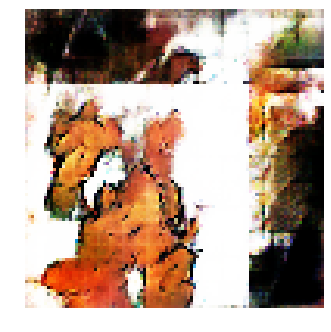


Epoch: 31680, D: 0.1334, G: 2.515
Epoch: 31681, D: -6.523, G: 2.756
Epoch: 31682, D: -5.579, G: 3.24
Epoch: 31683, D: -5.919, G: 1.762
Epoch: 31684, D: -6.551, G: 3.698
Epoch: 31685, D: -4.108, G: 4.288
Epoch: 31686, D: -5.63, G: 4.55
Epoch: 31687, D: -4.846, G: 3.492
Epoch: 31688, D: -5.44, G: 4.272
Epoch: 31689, D: -7.268, G: 4.678
Epoch: 31690, D: -4.3, G: 5.931
Epoch: 31691, D: -5.633, G: 3.501
Epoch: 31692, D: 2.538, G: 2.508
Epoch: 31693, D: -0.452, G: 3.267
Epoch: 31694, D: -1.321, G: 3.468
Epoch: 31695, D: -3.837, G: 3.683
Epoch: 31696, D: -3.763, G: 2.996
Epoch: 31697, D: -4.976, G: 4.102
Epoch: 31698, D: -6.537, G: 5.213
Epoch: 31699, D: -4.919, G: 2.125


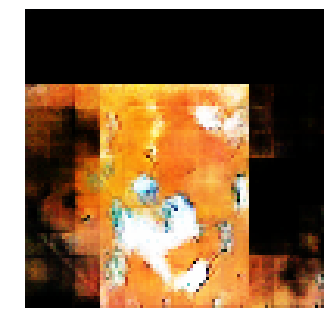


Epoch: 31700, D: -6.175, G: 3.955
Epoch: 31701, D: -5.938, G: 4.311
Epoch: 31702, D: -5.718, G: 2.1
Epoch: 31703, D: -5.878, G: 4.19
Epoch: 31704, D: -5.866, G: 2.814
Epoch: 31705, D: -6.525, G: 4.526
Epoch: 31706, D: -6.235, G: 4.363
Epoch: 31707, D: -4.924, G: 3.985
Epoch: 31708, D: -5.579, G: 3.422
Epoch: 31709, D: -5.701, G: 4.92
Epoch: 31710, D: -4.435, G: 3.171
Epoch: 31711, D: -2.934, G: 4.889
Epoch: 31712, D: -3.824, G: 3.492
Epoch: 31713, D: -5.696, G: 2.638
Epoch: 31714, D: -6.029, G: 2.839
Epoch: 31715, D: -5.422, G: 4.726
Epoch: 31716, D: -2.831, G: 3.377
Epoch: 31717, D: -4.014, G: 5.276
Epoch: 31718, D: -2.208, G: 4.573
Epoch: 31719, D: -3.502, G: 2.859


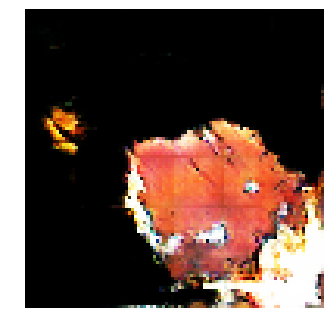


Epoch: 31720, D: -4.72, G: 3.477
Epoch: 31721, D: -4.796, G: 2.317
Epoch: 31722, D: -5.051, G: 4.265
Epoch: 31723, D: -5.69, G: 2.588
Epoch: 31724, D: -5.396, G: 3.363
Epoch: 31725, D: -4.986, G: 5.635
Epoch: 31726, D: -5.744, G: 5.711
Epoch: 31727, D: -6.64, G: 3.692
Epoch: 31728, D: -6.985, G: 1.476
Epoch: 31729, D: -5.978, G: 3.917
Epoch: 31730, D: -5.069, G: 4.77
Epoch: 31731, D: -4.363, G: 5.428
Epoch: 31732, D: -3.112, G: 4.14
Epoch: 31733, D: -5.986, G: 3.638
Epoch: 31734, D: -5.792, G: 4.83
Epoch: 31735, D: -6.848, G: 5.401
Epoch: 31736, D: -4.379, G: 3.427
Epoch: 31737, D: -5.966, G: 4.889
Epoch: 31738, D: -6.522, G: 4.164
Epoch: 31739, D: -6.218, G: 4.419


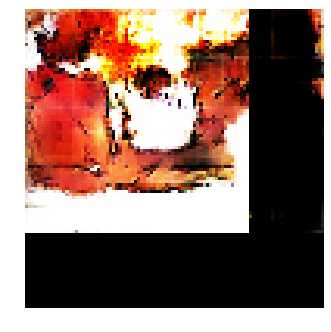


Epoch: 31740, D: -4.649, G: 5.425
Epoch: 31741, D: -2.943, G: 3.344
Epoch: 31742, D: -6.694, G: 3.874
Epoch: 31743, D: -6.297, G: 3.823
Epoch: 31744, D: -7.123, G: 4.032
Epoch: 31745, D: -4.679, G: 2.391
Epoch: 31746, D: -4.41, G: 3.741
Epoch: 31747, D: -4.791, G: 4.212
Epoch: 31748, D: -5.53, G: 2.484
Epoch: 31749, D: -6.286, G: 2.005
Epoch: 31750, D: -2.174, G: 1.579
Epoch: 31751, D: -5.374, G: 3.23
Epoch: 31752, D: -5.768, G: 2.565
Epoch: 31753, D: -3.948, G: 4.948
Epoch: 31754, D: -5.646, G: 1.959
Epoch: 31755, D: -6.624, G: 4.082
Epoch: 31756, D: -6.616, G: 2.481
Epoch: 31757, D: -7.254, G: 3.945
Epoch: 31758, D: -5.25, G: 2.476
Epoch: 31759, D: -6.063, G: 4.627


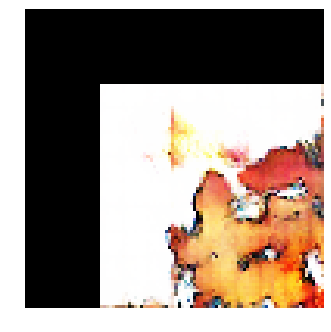


Epoch: 31760, D: -5.526, G: 2.927
Epoch: 31761, D: -7.661, G: 1.69
Epoch: 31762, D: -6.659, G: 4.191
Epoch: 31763, D: -5.665, G: 4.146
Epoch: 31764, D: -6.316, G: 2.959
Epoch: 31765, D: -6.038, G: 5.322
Epoch: 31766, D: -5.944, G: 4.13
Epoch: 31767, D: -5.769, G: 4.928
Epoch: 31768, D: -6.57, G: 3.104
Epoch: 31769, D: -7.178, G: 4.338
Epoch: 31770, D: -4.131, G: 3.497
Epoch: 31771, D: -3.744, G: 2.66
Epoch: 31772, D: -4.505, G: 3.045
Epoch: 31773, D: -5.187, G: 4.084
Epoch: 31774, D: -5.657, G: 4.224
Epoch: 31775, D: -5.538, G: 3.354
Epoch: 31776, D: -5.114, G: 4.035
Epoch: 31777, D: -4.895, G: 2.909
Epoch: 31778, D: -5.329, G: 4.85
Epoch: 31779, D: -6.723, G: 3.393


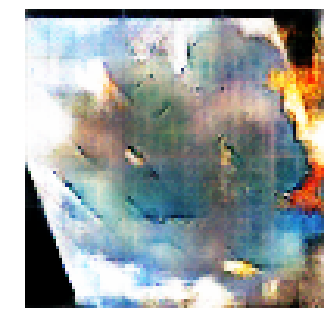


Epoch: 31780, D: -6.109, G: 2.965
Epoch: 31781, D: -5.399, G: 3.984
Epoch: 31782, D: -6.845, G: 2.293
Epoch: 31783, D: -4.35, G: 2.97
Epoch: 31784, D: -3.851, G: 3.27
Epoch: 31785, D: -4.988, G: 3.76
Epoch: 31786, D: -3.159, G: 1.91
Epoch: 31787, D: -4.846, G: 3.834
Epoch: 31788, D: -4.869, G: 2.661
Epoch: 31789, D: -4.944, G: 3.407
Epoch: 31790, D: -5.063, G: 2.907
Epoch: 31791, D: -5.178, G: 3.799
Epoch: 31792, D: -4.956, G: 3.49
Epoch: 31793, D: -7.415, G: 4.517
Epoch: 31794, D: -6.458, G: 4.697
Epoch: 31795, D: -5.242, G: 4.091
Epoch: 31796, D: -4.951, G: 4.009
Epoch: 31797, D: -4.024, G: 3.89
Epoch: 31798, D: -5.405, G: 3.304
Epoch: 31799, D: -5.289, G: 2.358


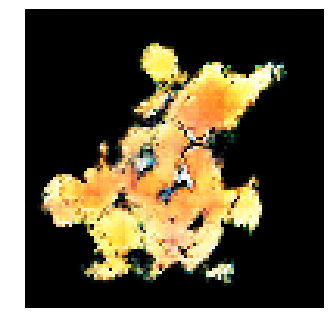


Epoch: 31800, D: -5.815, G: 4.013
Epoch: 31801, D: -6.868, G: 3.236
Epoch: 31802, D: -6.458, G: 4.546
Epoch: 31803, D: -6.292, G: 3.717
Epoch: 31804, D: -6.585, G: 5.134
Epoch: 31805, D: -4.072, G: 4.432
Epoch: 31806, D: -4.935, G: 4.28
Epoch: 31807, D: -5.0, G: 4.677
Epoch: 31808, D: -6.412, G: 3.953
Epoch: 31809, D: -6.965, G: 5.521
Epoch: 31810, D: -5.893, G: 4.345
Epoch: 31811, D: -6.848, G: 5.171
Epoch: 31812, D: -4.269, G: 4.518
Epoch: 31813, D: -3.536, G: 3.156
Epoch: 31814, D: -4.623, G: 3.842
Epoch: 31815, D: -4.26, G: 1.888
Epoch: 31816, D: -4.47, G: 4.654
Epoch: 31817, D: -4.641, G: 4.114
Epoch: 31818, D: -5.419, G: 3.612
Epoch: 31819, D: -4.518, G: 3.0


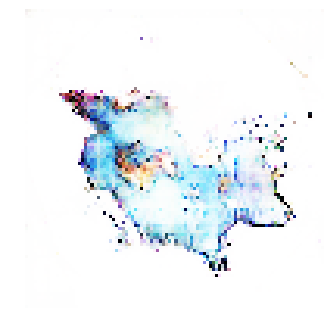


Epoch: 31820, D: -4.957, G: 3.85
Epoch: 31821, D: -4.486, G: 3.076
Epoch: 31822, D: -5.425, G: 4.896
Epoch: 31823, D: -5.278, G: 3.246
Epoch: 31824, D: -5.516, G: 3.28
Epoch: 31825, D: -4.128, G: 4.591
Epoch: 31826, D: -6.484, G: 5.009
Epoch: 31827, D: -6.341, G: 4.884
Epoch: 31828, D: -5.386, G: 3.767
Epoch: 31829, D: -5.677, G: 3.574
Epoch: 31830, D: -3.899, G: 2.989
Epoch: 31831, D: -5.177, G: 5.399
Epoch: 31832, D: -5.25, G: 4.35
Epoch: 31833, D: -6.511, G: 3.878
Epoch: 31834, D: -5.925, G: 4.669
Epoch: 31835, D: -5.866, G: 5.06
Epoch: 31836, D: -6.164, G: 4.261
Epoch: 31837, D: -6.161, G: 3.247
Epoch: 31838, D: -5.97, G: 4.475
Epoch: 31839, D: -5.073, G: 5.668


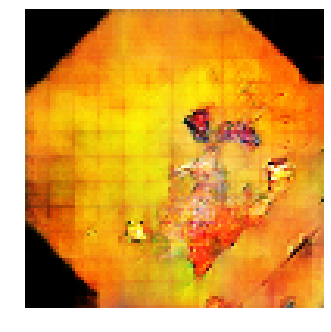


Epoch: 31840, D: -5.281, G: 3.729
Epoch: 31841, D: -5.204, G: 3.823
Epoch: 31842, D: -4.95, G: 2.569
Epoch: 31843, D: -4.151, G: 3.249
Epoch: 31844, D: -4.189, G: 6.609
Epoch: 31845, D: -5.492, G: 3.79
Epoch: 31846, D: -6.002, G: 4.326
Epoch: 31847, D: -4.648, G: 3.518
Epoch: 31848, D: -5.661, G: 5.01
Epoch: 31849, D: -6.039, G: 4.658
Epoch: 31850, D: -4.327, G: 4.357
Epoch: 31851, D: -5.676, G: 3.594
Epoch: 31852, D: -5.681, G: 4.09
Epoch: 31853, D: -6.364, G: 4.417
Epoch: 31854, D: -6.5, G: 3.053
Epoch: 31855, D: -6.198, G: 6.661
Epoch: 31856, D: -5.606, G: 3.33
Epoch: 31857, D: -6.043, G: 5.711
Epoch: 31858, D: -5.653, G: 4.644
Epoch: 31859, D: -6.758, G: 3.746


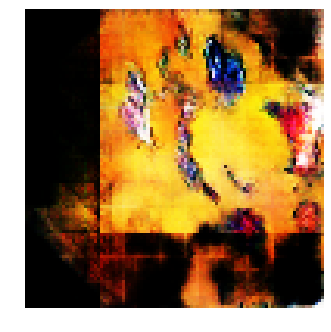


Epoch: 31860, D: -5.355, G: 5.054
Epoch: 31861, D: -5.257, G: 1.97
Epoch: 31862, D: -4.483, G: 4.874
Epoch: 31863, D: -4.417, G: 4.188
Epoch: 31864, D: -5.512, G: 3.88
Epoch: 31865, D: -4.948, G: 4.411
Epoch: 31866, D: -5.379, G: 4.574
Epoch: 31867, D: -5.206, G: 3.349
Epoch: 31868, D: -6.09, G: 2.182
Epoch: 31869, D: -6.702, G: 2.772
Epoch: 31870, D: -5.92, G: 5.501
Epoch: 31871, D: -5.304, G: 2.708
Epoch: 31872, D: -6.066, G: 3.53
Epoch: 31873, D: -4.537, G: 3.954
Epoch: 31874, D: -5.329, G: 3.172
Epoch: 31875, D: -5.371, G: 3.228
Epoch: 31876, D: -5.396, G: 2.408
Epoch: 31877, D: -5.417, G: 4.325
Epoch: 31878, D: -5.009, G: 3.385
Epoch: 31879, D: -7.118, G: 3.665


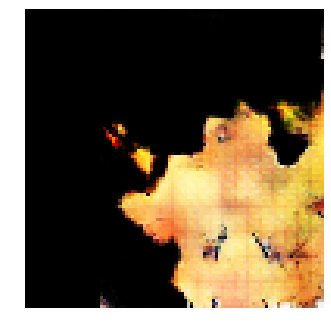


Epoch: 31880, D: -5.123, G: 4.43
Epoch: 31881, D: -5.149, G: 3.202
Epoch: 31882, D: -7.805, G: 3.633
Epoch: 31883, D: -4.409, G: 2.981
Epoch: 31884, D: -4.929, G: 4.244
Epoch: 31885, D: -4.829, G: 4.445
Epoch: 31886, D: -4.589, G: 4.46
Epoch: 31887, D: -5.485, G: 3.524
Epoch: 31888, D: -5.814, G: 3.498
Epoch: 31889, D: -7.13, G: 4.799
Epoch: 31890, D: -5.432, G: 3.679
Epoch: 31891, D: -5.437, G: 3.754
Epoch: 31892, D: -6.32, G: 2.41
Epoch: 31893, D: -7.661, G: 3.025
Epoch: 31894, D: -5.59, G: 3.784
Epoch: 31895, D: -6.488, G: 3.648
Epoch: 31896, D: -6.227, G: 3.115
Epoch: 31897, D: -5.468, G: 5.459
Epoch: 31898, D: -5.035, G: 5.484
Epoch: 31899, D: -5.058, G: 3.962


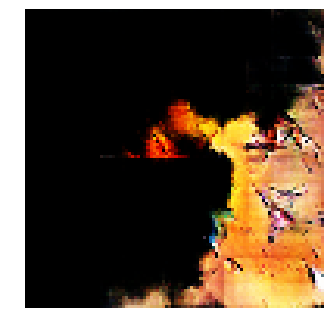


Epoch: 31900, D: -6.272, G: 3.036
Epoch: 31901, D: -5.45, G: 4.95
Epoch: 31902, D: -5.052, G: 3.457
Epoch: 31903, D: -3.948, G: 4.695
Epoch: 31904, D: -6.207, G: 3.685
Epoch: 31905, D: -6.176, G: 3.915
Epoch: 31906, D: -6.438, G: 2.401
Epoch: 31907, D: -4.042, G: 3.828
Epoch: 31908, D: -6.874, G: 3.346
Epoch: 31909, D: -6.875, G: 4.16
Epoch: 31910, D: -6.965, G: 3.032
Epoch: 31911, D: -4.989, G: 3.75
Epoch: 31912, D: -7.005, G: 6.328
Epoch: 31913, D: -6.343, G: 5.419
Epoch: 31914, D: -6.156, G: 3.693
Epoch: 31915, D: -4.041, G: 4.373
Epoch: 31916, D: -6.091, G: 4.184
Epoch: 31917, D: -5.246, G: 2.294
Epoch: 31918, D: -4.661, G: 5.993
Epoch: 31919, D: -5.562, G: 3.243


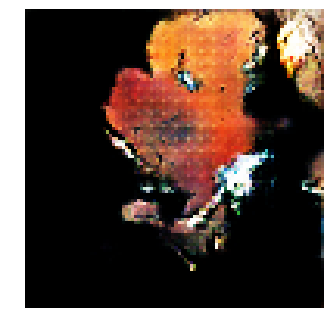


Epoch: 31920, D: -4.173, G: 4.695
Epoch: 31921, D: -6.113, G: 3.739
Epoch: 31922, D: -6.077, G: 2.083
Epoch: 31923, D: -6.284, G: 4.785
Epoch: 31924, D: -4.682, G: 4.405
Epoch: 31925, D: -5.416, G: 4.103
Epoch: 31926, D: -4.981, G: 2.693
Epoch: 31927, D: -4.522, G: 4.481
Epoch: 31928, D: -5.92, G: 2.254
Epoch: 31929, D: -5.357, G: 4.248
Epoch: 31930, D: -4.293, G: 5.868
Epoch: 31931, D: -6.41, G: 4.099
Epoch: 31932, D: -5.979, G: 2.134
Epoch: 31933, D: -5.233, G: 1.35
Epoch: 31934, D: -6.223, G: 3.042
Epoch: 31935, D: -6.046, G: 5.189
Epoch: 31936, D: -5.503, G: 3.212
Epoch: 31937, D: -5.882, G: 4.377
Epoch: 31938, D: -5.073, G: 4.536
Epoch: 31939, D: -5.388, G: 2.653


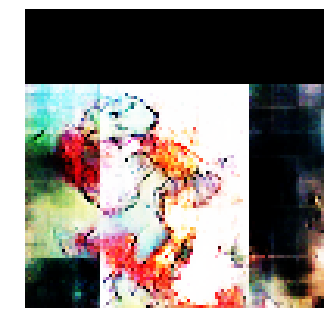


Epoch: 31940, D: -6.031, G: 3.375
Epoch: 31941, D: -4.78, G: 4.128
Epoch: 31942, D: -6.414, G: 4.231
Epoch: 31943, D: -4.836, G: 4.899
Epoch: 31944, D: -4.787, G: 4.915
Epoch: 31945, D: -5.686, G: 5.335
Epoch: 31946, D: -4.583, G: 4.533
Epoch: 31947, D: -6.019, G: 4.588
Epoch: 31948, D: -4.873, G: 6.064
Epoch: 31949, D: -6.275, G: 2.006
Epoch: 31950, D: -5.291, G: 2.681
Epoch: 31951, D: -5.871, G: 5.363
Epoch: 31952, D: -4.818, G: 4.719
Epoch: 31953, D: -5.107, G: 3.617
Epoch: 31954, D: -5.234, G: 5.426
Epoch: 31955, D: -6.106, G: 4.147
Epoch: 31956, D: -5.735, G: 3.789
Epoch: 31957, D: -5.108, G: 3.593
Epoch: 31958, D: -5.958, G: 4.059
Epoch: 31959, D: -6.186, G: 5.052


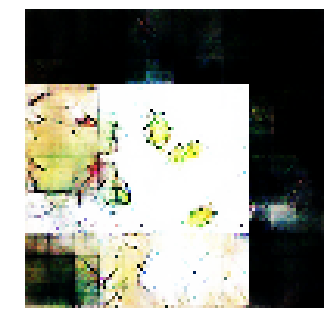


Epoch: 31960, D: -4.165, G: 5.259
Epoch: 31961, D: -5.459, G: 3.922
Epoch: 31962, D: -7.107, G: 3.54
Epoch: 31963, D: -4.803, G: 3.282
Epoch: 31964, D: -5.201, G: 3.108
Epoch: 31965, D: -5.531, G: 4.196
Epoch: 31966, D: -5.116, G: 4.102
Epoch: 31967, D: -5.61, G: 4.01
Epoch: 31968, D: -6.044, G: 1.872
Epoch: 31969, D: -4.52, G: 4.722
Epoch: 31970, D: -5.401, G: 4.293
Epoch: 31971, D: -5.349, G: 2.323
Epoch: 31972, D: -5.504, G: 2.701
Epoch: 31973, D: -4.917, G: 3.934
Epoch: 31974, D: -5.189, G: 4.997
Epoch: 31975, D: -6.184, G: 4.014
Epoch: 31976, D: -5.438, G: 5.347
Epoch: 31977, D: -5.733, G: 4.186
Epoch: 31978, D: -5.593, G: 4.845
Epoch: 31979, D: -5.555, G: 3.534


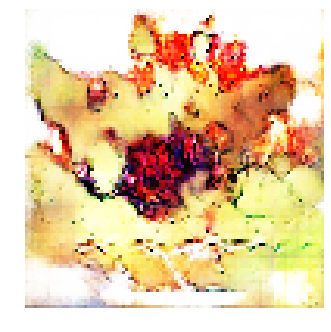


Epoch: 31980, D: -4.836, G: 3.239
Epoch: 31981, D: -4.957, G: 4.623
Epoch: 31982, D: -6.265, G: 4.093
Epoch: 31983, D: -7.192, G: 5.769
Epoch: 31984, D: -5.252, G: 3.101
Epoch: 31985, D: -5.992, G: 3.418
Epoch: 31986, D: -6.045, G: 3.865
Epoch: 31987, D: -6.749, G: 3.48
Epoch: 31988, D: -5.045, G: 2.61
Epoch: 31989, D: -5.53, G: 5.967
Epoch: 31990, D: -4.699, G: 2.805
Epoch: 31991, D: -5.669, G: 5.175
Epoch: 31992, D: -5.047, G: 5.32
Epoch: 31993, D: -4.778, G: 5.479
Epoch: 31994, D: -4.972, G: 5.157
Epoch: 31995, D: -4.263, G: 3.253
Epoch: 31996, D: -6.405, G: 4.689
Epoch: 31997, D: -4.45, G: 4.484
Epoch: 31998, D: -6.018, G: 5.046
Epoch: 31999, D: -7.028, G: 3.113


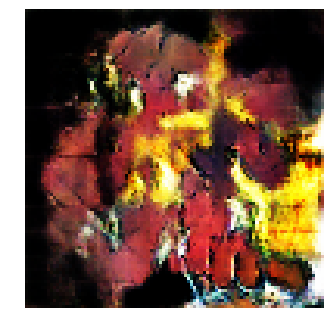


Epoch: 32000, D: -6.578, G: 5.474
Epoch: 32001, D: -5.406, G: 3.831
Epoch: 32002, D: -6.393, G: 4.861
Epoch: 32003, D: -5.14, G: 2.832
Epoch: 32004, D: -5.094, G: 4.54
Epoch: 32005, D: -6.218, G: 3.931
Epoch: 32006, D: -5.933, G: 2.464
Epoch: 32007, D: -5.303, G: 3.806
Epoch: 32008, D: -4.958, G: 4.216
Epoch: 32009, D: -6.288, G: 3.677
Epoch: 32010, D: -6.169, G: 5.257
Epoch: 32011, D: -6.371, G: 4.077
Epoch: 32012, D: -4.689, G: 4.185
Epoch: 32013, D: -5.086, G: 3.998
Epoch: 32014, D: -5.475, G: 2.617
Epoch: 32015, D: -5.914, G: 3.038
Epoch: 32016, D: -4.847, G: 3.754
Epoch: 32017, D: -4.874, G: 3.161
Epoch: 32018, D: -5.052, G: 3.81
Epoch: 32019, D: -7.508, G: 3.82


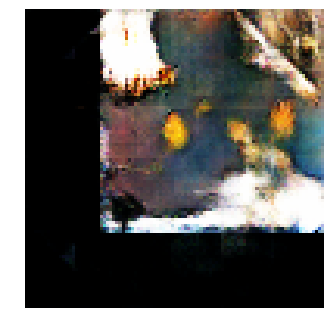


Epoch: 32020, D: -6.702, G: 3.318
Epoch: 32021, D: -5.927, G: 2.424
Epoch: 32022, D: -5.643, G: 4.619
Epoch: 32023, D: -6.518, G: 4.723
Epoch: 32024, D: -7.542, G: 3.451
Epoch: 32025, D: -5.802, G: 3.307
Epoch: 32026, D: -5.523, G: 3.61
Epoch: 32027, D: -6.382, G: 2.958
Epoch: 32028, D: -5.167, G: 3.518
Epoch: 32029, D: -4.092, G: 4.526
Epoch: 32030, D: -5.352, G: 3.872
Epoch: 32031, D: -5.158, G: 4.556
Epoch: 32032, D: -4.908, G: 4.284
Epoch: 32033, D: -5.475, G: 5.175
Epoch: 32034, D: -6.028, G: 6.046
Epoch: 32035, D: -6.986, G: 3.613
Epoch: 32036, D: -6.979, G: 3.708
Epoch: 32037, D: -5.532, G: 3.278
Epoch: 32038, D: -5.48, G: 4.674
Epoch: 32039, D: -5.851, G: 4.795


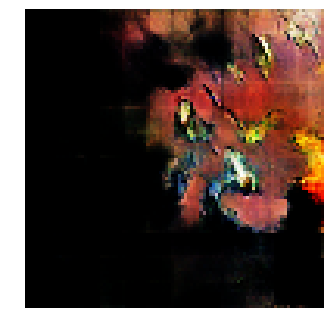


Epoch: 32040, D: -5.414, G: 5.491
Epoch: 32041, D: -4.894, G: 5.353
Epoch: 32042, D: -4.727, G: 4.648
Epoch: 32043, D: -4.844, G: 4.749
Epoch: 32044, D: -4.251, G: 3.732
Epoch: 32045, D: -6.694, G: 4.837
Epoch: 32046, D: -4.86, G: 5.058
Epoch: 32047, D: -6.033, G: 2.598
Epoch: 32048, D: -4.646, G: 2.338
Epoch: 32049, D: -6.154, G: 5.041
Epoch: 32050, D: -5.725, G: 3.746
Epoch: 32051, D: -6.348, G: 3.024
Epoch: 32052, D: -6.699, G: 3.864
Epoch: 32053, D: -4.464, G: 3.72
Epoch: 32054, D: -6.118, G: 3.668
Epoch: 32055, D: -6.543, G: 4.751
Epoch: 32056, D: -5.947, G: 5.838
Epoch: 32057, D: -6.202, G: 3.212
Epoch: 32058, D: -6.625, G: 2.492
Epoch: 32059, D: -6.181, G: 4.849


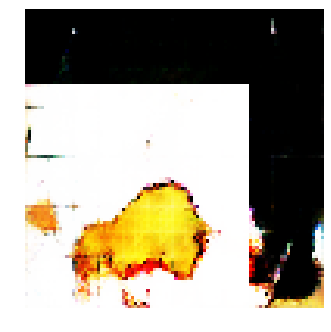


Epoch: 32060, D: -6.313, G: 5.624
Epoch: 32061, D: -5.032, G: 3.038
Epoch: 32062, D: -5.72, G: 3.047
Epoch: 32063, D: -5.918, G: 2.557
Epoch: 32064, D: -6.448, G: 2.113
Epoch: 32065, D: -6.223, G: 3.63
Epoch: 32066, D: -6.204, G: 2.503
Epoch: 32067, D: -5.576, G: 3.924
Epoch: 32068, D: -6.244, G: 4.356
Epoch: 32069, D: -6.573, G: 5.018
Epoch: 32070, D: -5.718, G: 3.605
Epoch: 32071, D: -5.508, G: 2.783
Epoch: 32072, D: -6.44, G: 2.309
Epoch: 32073, D: -5.687, G: 2.958
Epoch: 32074, D: -6.145, G: 3.532
Epoch: 32075, D: -5.598, G: 3.609
Epoch: 32076, D: -3.968, G: 2.849
Epoch: 32077, D: -5.97, G: 4.713
Epoch: 32078, D: -7.056, G: 4.913
Epoch: 32079, D: -5.449, G: 3.482


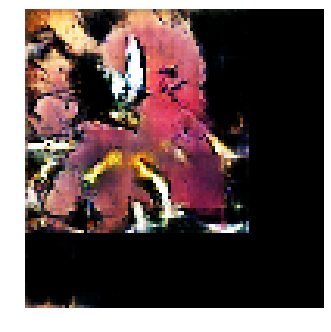


Epoch: 32080, D: -3.668, G: 3.434
Epoch: 32081, D: -5.651, G: 3.839
Epoch: 32082, D: -5.669, G: 4.291
Epoch: 32083, D: -5.33, G: 3.729
Epoch: 32084, D: -7.139, G: 3.803
Epoch: 32085, D: -6.328, G: 2.99
Epoch: 32086, D: -6.639, G: 3.585
Epoch: 32087, D: -4.479, G: 4.097
Epoch: 32088, D: -6.73, G: 4.293
Epoch: 32089, D: -5.349, G: 4.211
Epoch: 32090, D: -5.789, G: 5.114
Epoch: 32091, D: -6.231, G: 5.163
Epoch: 32092, D: -6.307, G: 4.329
Epoch: 32093, D: -5.014, G: 4.08
Epoch: 32094, D: -5.478, G: 4.246
Epoch: 32095, D: -6.523, G: 4.047
Epoch: 32096, D: -5.635, G: 3.877
Epoch: 32097, D: -6.082, G: 4.471
Epoch: 32098, D: -6.319, G: 3.717
Epoch: 32099, D: -5.584, G: 2.666


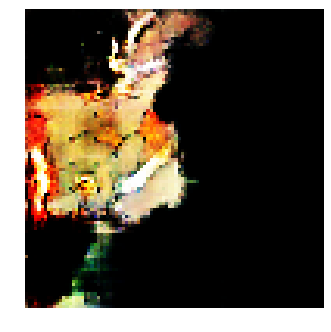


Epoch: 32100, D: -5.09, G: 2.296
Epoch: 32101, D: -3.447, G: 3.285
Epoch: 32102, D: -4.769, G: 3.692
Epoch: 32103, D: -4.505, G: 4.626
Epoch: 32104, D: -3.833, G: 5.109
Epoch: 32105, D: -5.675, G: 3.042
Epoch: 32106, D: -6.542, G: 3.776
Epoch: 32107, D: -6.146, G: 5.054
Epoch: 32108, D: -5.508, G: 4.659
Epoch: 32109, D: -5.842, G: 4.56
Epoch: 32110, D: -6.216, G: 4.537
Epoch: 32111, D: -5.931, G: 5.048
Epoch: 32112, D: -6.081, G: 4.494
Epoch: 32113, D: -4.692, G: 5.03
Epoch: 32114, D: -6.326, G: 4.084
Epoch: 32115, D: -7.014, G: 2.657
Epoch: 32116, D: -6.445, G: 2.54
Epoch: 32117, D: -6.584, G: 3.647
Epoch: 32118, D: -5.832, G: 5.94
Epoch: 32119, D: -5.338, G: 4.109


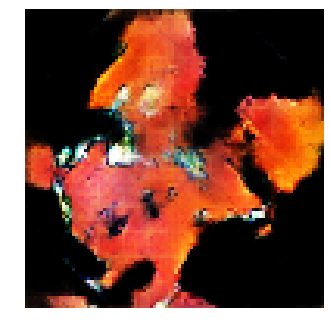


Epoch: 32120, D: -5.497, G: 3.969
Epoch: 32121, D: -5.65, G: 5.506
Epoch: 32122, D: -6.681, G: 5.408
Epoch: 32123, D: -4.562, G: 3.353
Epoch: 32124, D: -5.052, G: 4.034
Epoch: 32125, D: -5.443, G: 3.456
Epoch: 32126, D: -6.29, G: 2.798
Epoch: 32127, D: -6.065, G: 5.075
Epoch: 32128, D: -6.555, G: 4.341
Epoch: 32129, D: -5.453, G: 3.617
Epoch: 32130, D: -6.069, G: 3.258
Epoch: 32131, D: -6.135, G: 3.838
Epoch: 32132, D: -5.049, G: 4.727
Epoch: 32133, D: -5.383, G: 4.991
Epoch: 32134, D: -6.031, G: 4.666
Epoch: 32135, D: -6.648, G: 4.015
Epoch: 32136, D: -5.568, G: 3.145
Epoch: 32137, D: -5.77, G: 4.025
Epoch: 32138, D: -5.217, G: 4.108
Epoch: 32139, D: -6.246, G: 4.807


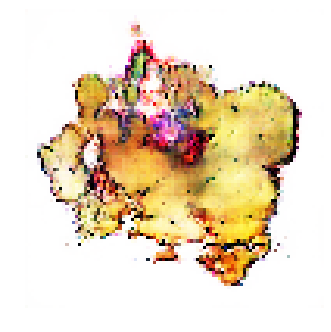


Epoch: 32140, D: -7.121, G: 4.424
Epoch: 32141, D: -6.844, G: 4.648
Epoch: 32142, D: -5.946, G: 4.075
Epoch: 32143, D: -5.396, G: 4.898
Epoch: 32144, D: -5.455, G: 2.933
Epoch: 32145, D: -6.005, G: 3.038
Epoch: 32146, D: -5.72, G: 3.987
Epoch: 32147, D: -6.466, G: 4.14
Epoch: 32148, D: -6.102, G: 2.712
Epoch: 32149, D: -6.679, G: 2.52
Epoch: 32150, D: -6.867, G: 3.135
Epoch: 32151, D: -4.661, G: 3.753
Epoch: 32152, D: -6.295, G: 4.088
Epoch: 32153, D: -6.692, G: 4.103
Epoch: 32154, D: -5.37, G: 4.359
Epoch: 32155, D: -6.76, G: 5.224
Epoch: 32156, D: -5.116, G: 3.614
Epoch: 32157, D: -4.483, G: 3.817
Epoch: 32158, D: -7.021, G: 3.139
Epoch: 32159, D: -4.287, G: 3.633


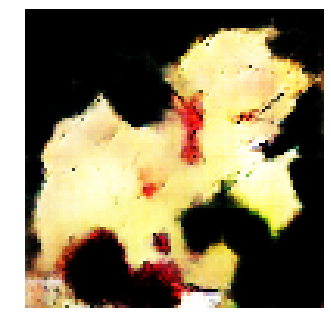


Epoch: 32160, D: -6.673, G: 4.363
Epoch: 32161, D: -6.671, G: 2.582
Epoch: 32162, D: -6.925, G: 2.823
Epoch: 32163, D: -4.863, G: 5.027
Epoch: 32164, D: -5.597, G: 2.738
Epoch: 32165, D: -6.457, G: 4.611
Epoch: 32166, D: -5.595, G: 5.084
Epoch: 32167, D: -6.219, G: 4.949
Epoch: 32168, D: -6.478, G: 2.232
Epoch: 32169, D: -4.608, G: 4.384
Epoch: 32170, D: -6.737, G: 3.199
Epoch: 32171, D: -4.819, G: 3.43
Epoch: 32172, D: -6.388, G: 1.825
Epoch: 32173, D: -5.625, G: 3.655
Epoch: 32174, D: -6.059, G: 4.765
Epoch: 32175, D: -6.221, G: 4.81
Epoch: 32176, D: -5.008, G: 3.818
Epoch: 32177, D: -5.673, G: 4.099
Epoch: 32178, D: -5.442, G: 4.698
Epoch: 32179, D: -5.283, G: 4.386


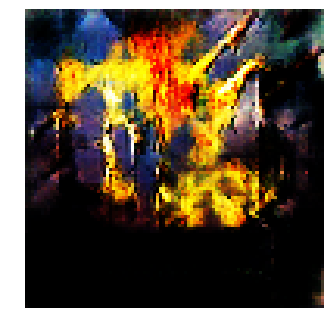


Epoch: 32180, D: -5.115, G: 4.676
Epoch: 32181, D: -6.487, G: 4.618
Epoch: 32182, D: -6.586, G: 4.404
Epoch: 32183, D: -5.931, G: 3.823
Epoch: 32184, D: -6.579, G: 3.86
Epoch: 32185, D: -4.899, G: 3.17
Epoch: 32186, D: -5.012, G: 4.405
Epoch: 32187, D: -6.0, G: 2.525
Epoch: 32188, D: -5.573, G: 3.751
Epoch: 32189, D: -4.477, G: 4.019
Epoch: 32190, D: -4.935, G: 4.987
Epoch: 32191, D: -6.237, G: 4.035
Epoch: 32192, D: -4.125, G: 4.697
Epoch: 32193, D: -5.331, G: 4.329
Epoch: 32194, D: -6.606, G: 3.301
Epoch: 32195, D: -5.882, G: 3.911
Epoch: 32196, D: -6.743, G: 4.272
Epoch: 32197, D: -5.903, G: 3.757
Epoch: 32198, D: -5.522, G: 3.778
Epoch: 32199, D: -6.077, G: 3.43


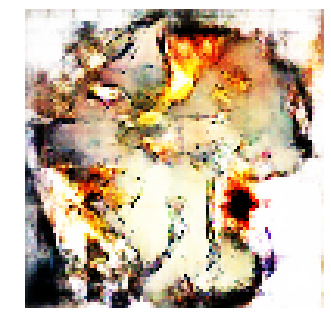


Epoch: 32200, D: -6.241, G: 4.077
Epoch: 32201, D: -4.554, G: 3.421
Epoch: 32202, D: -6.708, G: 5.583
Epoch: 32203, D: -4.905, G: 4.457
Epoch: 32204, D: -6.425, G: 4.056
Epoch: 32205, D: -5.733, G: 3.526
Epoch: 32206, D: -5.655, G: 3.493
Epoch: 32207, D: -6.735, G: 4.318
Epoch: 32208, D: -5.675, G: 3.03
Epoch: 32209, D: -6.406, G: 4.122
Epoch: 32210, D: -6.784, G: 3.379
Epoch: 32211, D: -5.951, G: 2.8
Epoch: 32212, D: -6.071, G: 2.854
Epoch: 32213, D: -5.503, G: 3.906
Epoch: 32214, D: -7.554, G: 3.316
Epoch: 32215, D: -5.692, G: 1.981
Epoch: 32216, D: -5.531, G: 3.307
Epoch: 32217, D: -5.15, G: 1.923
Epoch: 32218, D: -8.165, G: 3.685
Epoch: 32219, D: -5.43, G: 3.689


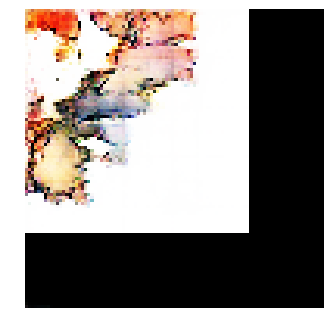


Epoch: 32220, D: -5.807, G: 5.05
Epoch: 32221, D: -4.996, G: 4.288
Epoch: 32222, D: -4.677, G: 4.78
Epoch: 32223, D: -6.751, G: 3.945
Epoch: 32224, D: -4.836, G: 2.892
Epoch: 32225, D: -4.961, G: 4.917
Epoch: 32226, D: -5.566, G: 4.659
Epoch: 32227, D: -6.503, G: 3.65
Epoch: 32228, D: -4.804, G: 3.703
Epoch: 32229, D: -6.963, G: 4.478
Epoch: 32230, D: -5.97, G: 2.412
Epoch: 32231, D: -4.983, G: 2.205
Epoch: 32232, D: -5.435, G: 4.836
Epoch: 32233, D: -5.51, G: 5.281
Epoch: 32234, D: -5.508, G: 4.226
Epoch: 32235, D: -6.142, G: 3.399
Epoch: 32236, D: -7.088, G: 4.049
Epoch: 32237, D: -4.781, G: 3.675
Epoch: 32238, D: -6.695, G: 4.539
Epoch: 32239, D: -5.049, G: 2.82


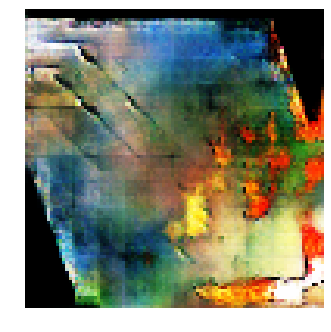


Epoch: 32240, D: -5.343, G: 4.516
Epoch: 32241, D: -6.249, G: 4.697
Epoch: 32242, D: -4.75, G: 3.435
Epoch: 32243, D: -6.821, G: 4.121
Epoch: 32244, D: -6.226, G: 3.851
Epoch: 32245, D: -5.289, G: 4.986
Epoch: 32246, D: -6.278, G: 3.966
Epoch: 32247, D: -6.236, G: 4.334
Epoch: 32248, D: -5.404, G: 3.998
Epoch: 32249, D: -5.979, G: 3.708
Epoch: 32250, D: -4.539, G: 3.826
Epoch: 32251, D: -5.694, G: 5.293
Epoch: 32252, D: -6.196, G: 3.234
Epoch: 32253, D: -4.651, G: 2.08
Epoch: 32254, D: -7.256, G: 3.731
Epoch: 32255, D: -6.306, G: 3.034
Epoch: 32256, D: -6.397, G: 2.15
Epoch: 32257, D: -5.841, G: 4.281
Epoch: 32258, D: -6.868, G: 3.266
Epoch: 32259, D: -5.958, G: 4.656


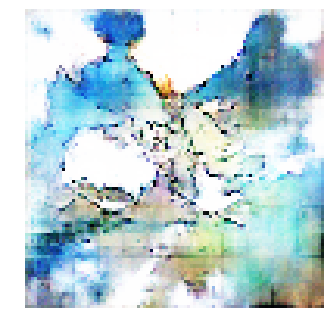


Epoch: 32260, D: -5.848, G: 3.032
Epoch: 32261, D: -6.228, G: 4.946
Epoch: 32262, D: -5.315, G: 4.895
Epoch: 32263, D: -6.656, G: 4.325
Epoch: 32264, D: -6.434, G: 4.492
Epoch: 32265, D: -5.427, G: 6.336
Epoch: 32266, D: -5.372, G: 2.673
Epoch: 32267, D: -7.213, G: 6.276
Epoch: 32268, D: -5.843, G: 2.455
Epoch: 32269, D: -6.217, G: 4.749
Epoch: 32270, D: -6.386, G: 3.014
Epoch: 32271, D: -6.873, G: 3.405
Epoch: 32272, D: -5.923, G: 2.818
Epoch: 32273, D: -6.287, G: 3.437
Epoch: 32274, D: -5.054, G: 3.028
Epoch: 32275, D: -5.874, G: 3.979
Epoch: 32276, D: -4.95, G: 4.539
Epoch: 32277, D: -5.003, G: 3.208
Epoch: 32278, D: -5.946, G: 3.604
Epoch: 32279, D: -6.232, G: 2.855


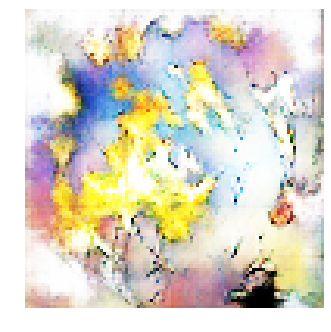


Epoch: 32280, D: -5.588, G: 2.403
Epoch: 32281, D: -5.039, G: 5.119
Epoch: 32282, D: -8.201, G: 4.412
Epoch: 32283, D: -4.94, G: 3.239
Epoch: 32284, D: -6.108, G: 3.379
Epoch: 32285, D: -5.881, G: 5.891
Epoch: 32286, D: -5.962, G: 5.738
Epoch: 32287, D: -5.99, G: 2.384
Epoch: 32288, D: -5.733, G: 4.608
Epoch: 32289, D: -6.022, G: 4.527
Epoch: 32290, D: -7.185, G: 3.223
Epoch: 32291, D: -5.75, G: 3.885
Epoch: 32292, D: -5.772, G: 3.147
Epoch: 32293, D: -3.709, G: 4.93
Epoch: 32294, D: -7.205, G: 4.011
Epoch: 32295, D: -5.189, G: 3.004
Epoch: 32296, D: -7.104, G: 4.001
Epoch: 32297, D: -6.463, G: 2.814
Epoch: 32298, D: -4.875, G: 3.612
Epoch: 32299, D: -6.312, G: 3.527


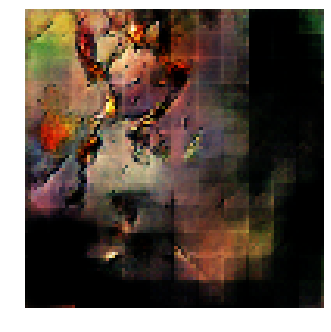


Epoch: 32300, D: -5.203, G: 5.292
Epoch: 32301, D: -6.622, G: 3.698
Epoch: 32302, D: -6.324, G: 3.264
Epoch: 32303, D: -5.193, G: 4.722
Epoch: 32304, D: -6.182, G: 4.281
Epoch: 32305, D: -6.68, G: 1.814
Epoch: 32306, D: -5.707, G: 3.264
Epoch: 32307, D: -6.191, G: 2.761
Epoch: 32308, D: -4.874, G: 3.188
Epoch: 32309, D: -5.099, G: 3.307
Epoch: 32310, D: -4.619, G: 3.624
Epoch: 32311, D: -5.936, G: 3.138
Epoch: 32312, D: -6.313, G: 3.974
Epoch: 32313, D: -5.97, G: 4.2
Epoch: 32314, D: -5.845, G: 2.779
Epoch: 32315, D: -5.492, G: 3.875
Epoch: 32316, D: -5.471, G: 3.595
Epoch: 32317, D: -5.279, G: 2.707
Epoch: 32318, D: -5.594, G: 5.429
Epoch: 32319, D: -6.696, G: 4.28


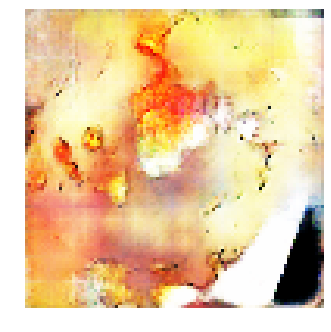


Epoch: 32320, D: -5.327, G: 6.545
Epoch: 32321, D: -6.353, G: 4.534
Epoch: 32322, D: -6.045, G: 2.507
Epoch: 32323, D: -4.697, G: 4.609
Epoch: 32324, D: -7.337, G: 4.135
Epoch: 32325, D: -5.685, G: 4.323
Epoch: 32326, D: -5.805, G: 3.215
Epoch: 32327, D: -5.215, G: 4.223
Epoch: 32328, D: -6.88, G: 2.616
Epoch: 32329, D: -7.225, G: 3.431
Epoch: 32330, D: -4.6, G: 3.258
Epoch: 32331, D: -5.898, G: 4.279
Epoch: 32332, D: -5.176, G: 4.879
Epoch: 32333, D: -5.255, G: 6.176
Epoch: 32334, D: -7.258, G: 4.069
Epoch: 32335, D: -5.922, G: 3.336
Epoch: 32336, D: -6.568, G: 2.594
Epoch: 32337, D: -5.992, G: 4.319
Epoch: 32338, D: -5.191, G: 5.406
Epoch: 32339, D: -5.815, G: 4.32


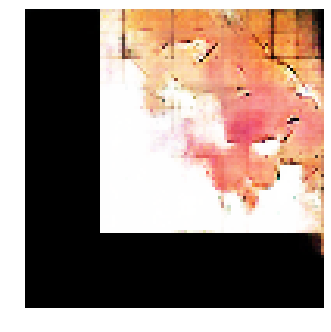


Epoch: 32340, D: -6.184, G: 4.41
Epoch: 32341, D: -5.948, G: 3.978
Epoch: 32342, D: -6.083, G: 5.475
Epoch: 32343, D: -6.02, G: 4.226
Epoch: 32344, D: -8.487, G: 3.948
Epoch: 32345, D: -7.001, G: 3.405
Epoch: 32346, D: -6.094, G: 6.899
Epoch: 32347, D: -6.786, G: 4.407
Epoch: 32348, D: -6.739, G: 4.291
Epoch: 32349, D: -5.475, G: 4.068
Epoch: 32350, D: -4.984, G: 3.831
Epoch: 32351, D: -7.249, G: 5.083
Epoch: 32352, D: -4.965, G: 3.508
Epoch: 32353, D: -5.103, G: 3.02
Epoch: 32354, D: -5.961, G: 3.105
Epoch: 32355, D: -6.899, G: 4.42
Epoch: 32356, D: -6.432, G: 4.397
Epoch: 32357, D: -6.992, G: 3.579
Epoch: 32358, D: -5.442, G: 4.478
Epoch: 32359, D: -6.607, G: 4.582


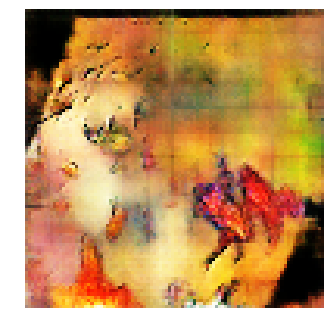


Epoch: 32360, D: -5.981, G: 4.172
Epoch: 32361, D: -4.59, G: 4.959
Epoch: 32362, D: -5.973, G: 3.923
Epoch: 32363, D: -5.924, G: 4.55
Epoch: 32364, D: -5.834, G: 3.656
Epoch: 32365, D: -5.34, G: 3.159
Epoch: 32366, D: -5.844, G: 1.935
Epoch: 32367, D: -6.178, G: 3.323
Epoch: 32368, D: -6.375, G: 2.968
Epoch: 32369, D: -6.75, G: 3.244
Epoch: 32370, D: -6.94, G: 2.96
Epoch: 32371, D: -6.11, G: 3.717
Epoch: 32372, D: -5.996, G: 3.316
Epoch: 32373, D: -5.268, G: 2.431
Epoch: 32374, D: -5.284, G: 3.267
Epoch: 32375, D: -5.581, G: 3.285
Epoch: 32376, D: -6.078, G: 4.246
Epoch: 32377, D: -6.735, G: 3.688
Epoch: 32378, D: -6.912, G: 2.769
Epoch: 32379, D: -7.846, G: 3.797


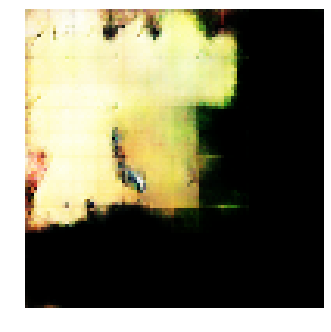


Epoch: 32380, D: -6.85, G: 4.348
Epoch: 32381, D: -5.805, G: 3.552
Epoch: 32382, D: -6.984, G: 3.613
Epoch: 32383, D: -4.742, G: 3.684
Epoch: 32384, D: -6.813, G: 4.325
Epoch: 32385, D: -4.599, G: 3.083
Epoch: 32386, D: -5.08, G: 3.114
Epoch: 32387, D: -5.473, G: 3.763
Epoch: 32388, D: -5.108, G: 4.068
Epoch: 32389, D: -4.939, G: 3.373
Epoch: 32390, D: -5.247, G: 2.943
Epoch: 32391, D: -6.448, G: 3.922
Epoch: 32392, D: -6.486, G: 5.185
Epoch: 32393, D: -7.455, G: 3.441
Epoch: 32394, D: -6.02, G: 4.828
Epoch: 32395, D: -5.927, G: 3.563
Epoch: 32396, D: -5.738, G: 3.617
Epoch: 32397, D: -6.094, G: 2.959
Epoch: 32398, D: -5.821, G: 3.71
Epoch: 32399, D: -5.7, G: 3.661


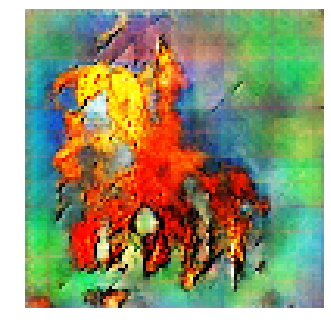


Epoch: 32400, D: -5.979, G: 2.963
Epoch: 32401, D: -5.373, G: 3.273
Epoch: 32402, D: -6.512, G: 4.261
Epoch: 32403, D: -5.417, G: 3.698
Epoch: 32404, D: -6.249, G: 3.904
Epoch: 32405, D: -5.948, G: 3.425
Epoch: 32406, D: -6.228, G: 4.956
Epoch: 32407, D: -6.443, G: 3.608
Epoch: 32408, D: -5.481, G: 4.142
Epoch: 32409, D: -6.245, G: 2.686
Epoch: 32410, D: -6.45, G: 3.066
Epoch: 32411, D: -6.03, G: 4.152
Epoch: 32412, D: -8.441, G: 4.29
Epoch: 32413, D: -5.332, G: 2.864
Epoch: 32414, D: -5.034, G: 4.099
Epoch: 32415, D: -5.451, G: 3.895
Epoch: 32416, D: -6.324, G: 4.936
Epoch: 32417, D: -5.325, G: 4.948
Epoch: 32418, D: -5.638, G: 3.218
Epoch: 32419, D: -6.227, G: 5.902


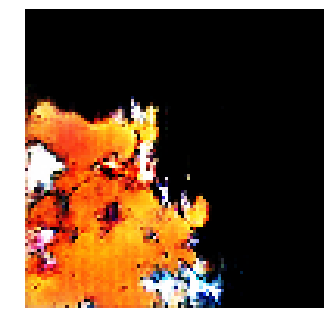


Epoch: 32420, D: -5.582, G: 4.237
Epoch: 32421, D: -5.949, G: 2.095
Epoch: 32422, D: -6.502, G: 4.532
Epoch: 32423, D: -5.626, G: 4.878
Epoch: 32424, D: -5.035, G: 3.671
Epoch: 32425, D: -7.14, G: 3.145
Epoch: 32426, D: -5.847, G: 5.084
Epoch: 32427, D: -5.805, G: 2.621
Epoch: 32428, D: -5.884, G: 4.372
Epoch: 32429, D: -6.671, G: 5.095
Epoch: 32430, D: -6.707, G: 4.097
Epoch: 32431, D: -6.354, G: 3.462
Epoch: 32432, D: -5.36, G: 3.137
Epoch: 32433, D: -5.969, G: 5.467
Epoch: 32434, D: -6.654, G: 4.419
Epoch: 32435, D: -6.394, G: 3.812
Epoch: 32436, D: -6.765, G: 3.514
Epoch: 32437, D: -6.375, G: 5.295
Epoch: 32438, D: -6.264, G: 4.087
Epoch: 32439, D: -6.494, G: 3.51


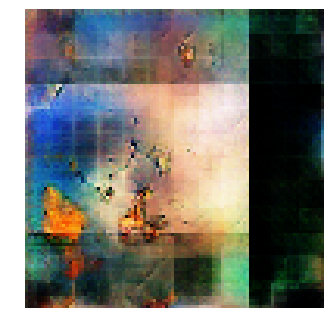


Epoch: 32440, D: -5.675, G: 5.332
Epoch: 32441, D: -6.383, G: 3.271
Epoch: 32442, D: -5.398, G: 2.633
Epoch: 32443, D: -5.757, G: 2.33
Epoch: 32444, D: -6.028, G: 3.972
Epoch: 32445, D: -5.566, G: 4.098
Epoch: 32446, D: -6.442, G: 3.398
Epoch: 32447, D: -5.918, G: 2.805
Epoch: 32448, D: -6.186, G: 2.742
Epoch: 32449, D: -4.819, G: 3.855
Epoch: 32450, D: -6.371, G: 2.544
Epoch: 32451, D: -6.16, G: 3.317
Epoch: 32452, D: -5.727, G: 1.732
Epoch: 32453, D: -6.533, G: 3.572
Epoch: 32454, D: -5.889, G: 2.824
Epoch: 32455, D: -4.899, G: 2.992
Epoch: 32456, D: -6.056, G: 4.005
Epoch: 32457, D: -7.741, G: 4.811
Epoch: 32458, D: -5.724, G: 2.822
Epoch: 32459, D: -5.971, G: 4.561


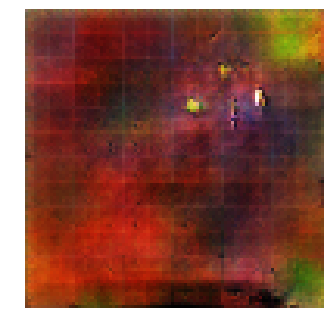


Epoch: 32460, D: -5.301, G: 4.021
Epoch: 32461, D: -6.088, G: 3.468
Epoch: 32462, D: -5.339, G: 3.659
Epoch: 32463, D: -5.926, G: 3.808
Epoch: 32464, D: -5.651, G: 3.63
Epoch: 32465, D: -7.347, G: 2.291
Epoch: 32466, D: -6.567, G: 4.707
Epoch: 32467, D: -5.846, G: 3.962
Epoch: 32468, D: -5.63, G: 3.356
Epoch: 32469, D: -5.396, G: 3.303
Epoch: 32470, D: -6.421, G: 1.924
Epoch: 32471, D: -6.195, G: 3.501
Epoch: 32472, D: -5.725, G: 5.011
Epoch: 32473, D: -5.43, G: 3.631
Epoch: 32474, D: -5.808, G: 4.635
Epoch: 32475, D: -6.709, G: 4.791
Epoch: 32476, D: -6.643, G: 4.372
Epoch: 32477, D: -7.086, G: 3.389
Epoch: 32478, D: -5.42, G: 3.365
Epoch: 32479, D: -5.447, G: 4.426


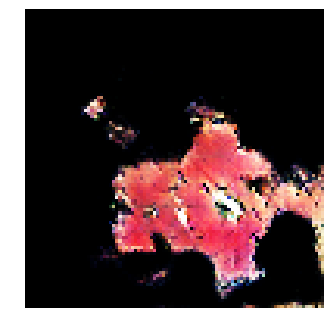


Epoch: 32480, D: -6.172, G: 4.072
Epoch: 32481, D: -5.667, G: 3.891
Epoch: 32482, D: -6.546, G: 4.222
Epoch: 32483, D: -5.314, G: 5.29
Epoch: 32484, D: -5.832, G: 2.478
Epoch: 32485, D: -6.349, G: 3.594
Epoch: 32486, D: -6.176, G: 3.579
Epoch: 32487, D: -6.498, G: 2.832
Epoch: 32488, D: -6.169, G: 2.909
Epoch: 32489, D: -7.131, G: 4.968
Epoch: 32490, D: -6.928, G: 3.817
Epoch: 32491, D: -6.152, G: 3.798
Epoch: 32492, D: -5.149, G: 3.679
Epoch: 32493, D: -4.639, G: 3.997
Epoch: 32494, D: -5.855, G: 3.994
Epoch: 32495, D: -6.534, G: 4.796
Epoch: 32496, D: -6.341, G: 3.147
Epoch: 32497, D: -5.621, G: 3.776
Epoch: 32498, D: -5.989, G: 3.579
Epoch: 32499, D: -6.148, G: 2.556


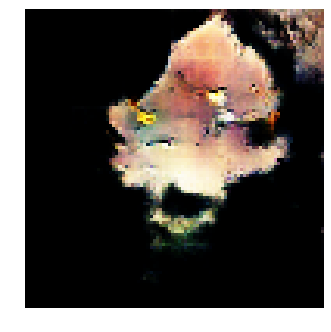


Epoch: 32500, D: -6.539, G: 4.079
Epoch: 32501, D: -5.494, G: 3.915
Epoch: 32502, D: -6.614, G: 1.599
Epoch: 32503, D: -4.797, G: 2.787
Epoch: 32504, D: -4.705, G: 3.181
Epoch: 32505, D: -6.414, G: 5.161
Epoch: 32506, D: -5.333, G: 4.486
Epoch: 32507, D: -6.979, G: 4.408
Epoch: 32508, D: -6.7, G: 4.735
Epoch: 32509, D: -5.59, G: 2.894
Epoch: 32510, D: -6.978, G: 4.451
Epoch: 32511, D: -5.665, G: 2.887
Epoch: 32512, D: -6.771, G: 4.555
Epoch: 32513, D: -6.748, G: 2.885
Epoch: 32514, D: -6.797, G: 5.592
Epoch: 32515, D: -6.116, G: 4.152
Epoch: 32516, D: -5.937, G: 3.577
Epoch: 32517, D: -7.866, G: 3.554
Epoch: 32518, D: -5.71, G: 2.457
Epoch: 32519, D: -5.877, G: 3.959


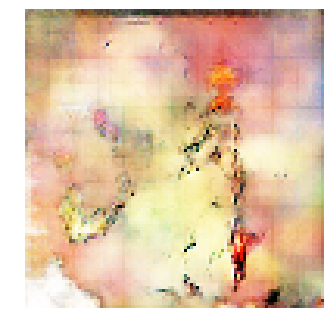


Epoch: 32520, D: -5.926, G: 3.091
Epoch: 32521, D: -5.836, G: 4.193
Epoch: 32522, D: -6.42, G: 3.077
Epoch: 32523, D: -6.2, G: 4.848
Epoch: 32524, D: -5.17, G: 3.755
Epoch: 32525, D: -5.571, G: 4.311
Epoch: 32526, D: -5.749, G: 4.004
Epoch: 32527, D: -5.871, G: 4.32
Epoch: 32528, D: -5.664, G: 6.594
Epoch: 32529, D: -5.605, G: 3.936
Epoch: 32530, D: -5.336, G: 5.104
Epoch: 32531, D: -5.397, G: 4.046
Epoch: 32532, D: -5.822, G: 3.791


In [0]:
#with tf.Session() as sess:
sess = tf.Session()
saver = tf.train.Saver()
#sess.run(tf.global_variables_initializer())
#print('Initialization done!')


#Test saving and loading
#save_path = saver.save(sess, 'drive/Pokemon/Checkpoints/model.ckpt')
ckpt = tf.train.latest_checkpoint('drive/Pokemon_Fire/Final_Checkpoints')
print(ckpt)
saver.restore(sess,ckpt)
print('Restored!')

run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,saver,num_epoch=15000)
 
save_inputs ={"isTrain":isTrain}
save_outputs = {"generator/generator_out":G_sample}

tf.saved_model.simple_save(sess, 'drive/Pokemon_Fire/Saved_model_Final',save_inputs,save_outputs)

In [0]:
save_inputs ={"isTrain":isTrain}
save_outputs = {"generator/generator_out":G_sample}

tf.saved_model.simple_save(sess, 'drive/Pokemon/Saved_modelGP',save_inputs,save_outputs)

In [0]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 10.4 GB  | Proc size: 5.2 GB
GPU RAM Free: 503MB | Used: 10936MB | Util  96% | Total 11439MB


In [0]:
!ps ax | grep python

   82 ?        Sl     0:10 /usr/bin/python2 /usr/local/bin/jupyter-notebook -y --no-browser --log-level=DEBUG --debug --NotebookApp.allow_origin="*" --NotebookApp.log_format="%(message)s" --NotebookApp.disable_check_xsrf=True --NotebookApp.token= --Session.key="" --Session.keyfile="" --ContentsManager.untitled_directory="Untitled Folder" --ContentsManager.untitled_file="Untitled File" --ContentsManager.untitled_notebook="Untitled Notebook" --KernelManager.autorestart=True --MultiKernelManager.default_kernel_name="python2" --ip="172.28.0.2" --port=9000 --port-retries=0 --notebook-dir="/content" --NotebookApp.base_url=/tun/m/gpu-1oh0mpcgklgqc/
   90 ?        Ssl  223:25 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-14d934e3-be51-46ed-9bdb-cf6fa1f8fa07.json
24021 ?        Ssl    0:10 /usr/bin/python3 -m ipykernel_launcher -f /content/.local/share/jupyter/runtime/kernel-bd5eb725-93eb-4089-b928-3dc6365a54c7.json
30723 pts/0    Ss+    0:00 /bin/sh -c 

In [0]:
!kill -9 90

In [0]:
#Clear everything
!kill -9 -1

In [0]:
sess.close()